In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%%capture
! unzip drive/MyDrive/home-credit-default-risk.zip

In [3]:
%%capture
! git clone --recursive https://github.com/Microsoft/LightGBM
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;
! pip install optuna
! pip install shap
! pip install probatus
! pip install catboost

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gc
import sqlite3
import shap
from scipy import stats

# Dataset

The data is of home credit default risks. Dataset contains multiple tables including the current loan information as well as the information on previous loans from this and other loaners.

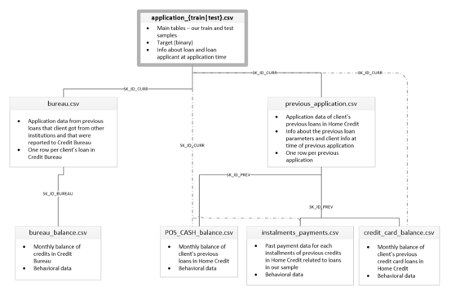

In [39]:
app_train = pd.read_csv("application_train.csv")
app_test = pd.read_csv("application_test.csv")

In [ ]:
bureau = pd.read_csv("bureau.csv")

In [ ]:
bureau_balance = pd.read_csv("bureau_balance.csv")

In [ ]:
installments_payments = pd.read_csv("installments_payments.csv")

In [ ]:
previous_applications = pd.read_csv("previous_application.csv")

In [55]:
credit_card_balance = pd.read_csv("credit_card_balance.csv")

In [ ]:
pos_cash_balance = pd.read_csv("POS_CASH_balance.csv")

In [5]:
def corrected_cramers(cf: pd.DataFrame) -> float:
    """Calculates corrected cramers v for given cross tabulation"""
    chi2 = stats.chi2_contingency(cf)[0]
    n = cf.sum().sum()
    phi2 = chi2 / n
    r, k = cf.shape
    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt((phi2_corr) / min(r_corr - 1, k_corr - 1))


def calc_cat_coor(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates categorical feature correlation using corrected cramers v

    Args:
        df: pandas dataframe which is expected to have only categorical features

    Returns:
        pandas dataframe with cramers v values for all pairs of features,
        similar to pd.DataFrame().corr() function
    """

    df_cols = df.columns
    n = df.shape[1]
    res_arr = np.zeros((n, n))
    tril_idx = zip(*np.tril_indices_from(res_arr))
    for idx in tril_idx:
        row, col = idx[0], idx[1]
        cf = pd.crosstab(df[df_cols[row]], df[df_cols[col]])
        res_arr[row, col] = corrected_cramers(cf)
    lower = np.tril(res_arr, k=-1)
    res_arr = res_arr + lower.T
    return pd.DataFrame(res_arr, columns=df_cols, index=df_cols)

In [6]:
from typing import Tuple


def vert_annot(
    axes: plt.axes, precision: int = 0, y: int = 5, rotation: int = 0
) -> None:
    """
    Annotate vertical bars in a barplot with its value
    """
    for bar in axes.patches:
        axes.annotate(
            format(bar.get_height(), f".{precision}f"),
            (bar.get_x() + bar.get_width() / 2, bar.get_height()),
            ha="center",
            va="center",
            xytext=(0, y),
            textcoords="offset points",
            rotation=rotation,
        )


def vert_text(ax: plt.axes, text: str, x: float, color: str = "k") -> None:
    """
    Vertical text annotation
    """
    y = ax.get_ylim()[1] * 0.5
    ax.annotate(
        text,
        (x, y),
        color=color,
        rotation="90",
        va="center",
        xytext=(4, 0),
        textcoords="offset points",
    )


def plot_pvalue(
    dist: np.ndarray, mean_diff: float, p_value: float, alt="two_sided"
) -> None:
    """
    Visualize the distribution of permuted mean differences
    Takes in values from permute_p
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.kdeplot(dist)
    ax.axvline(mean_diff, ls="--", color="b")
    vert_text(ax, "Sample mean difference", mean_diff)
    kde = ax.get_lines()[0].get_data()
    ax.set_title("Permuted distribution of difference in means", fontsize=15)

    if alt == "two_sided":
        ax.axvline(-mean_diff, ls="--", color="b")
        vert_text(ax, "-Sample mean difference", -mean_diff)
        ax.fill_between(
            kde[0],
            kde[1],
            where=(kde[0] < -abs(mean_diff)) | (kde[0] > abs(mean_diff)),
            interpolate=True,
            color="#FF7272",
        )
    elif alt == "greater":
        ax.fill_between(
            kde[0],
            kde[1],
            where=(kde[0] > mean_diff),
            interpolate=True,
            color="#FF7272",
        )
    elif alt == "less":
        ax.fill_between(
            kde[0],
            kde[1],
            where=(kde[0] < mean_diff),
            interpolate=True,
            color="#FF7272",
        )
    else:
        raise ValueError("alternative must be " "'less', 'greater' or 'two_sided'")
    plt.show()


def permute_p(
    data1: np.ndarray, data2: np.ndarray, n_perm: int, alt: str = "two_sided"
) -> Tuple[float, float, np.ndarray]:
    """
    Calculates p-value between two datasets means using permutations
    """
    mean_diff = data1.mean() - data2.mean()
    comb = np.concatenate((data1, data2))
    diffs = np.zeros((n_perm,))

    for i in range(n_perm):
        shuffled = np.random.permutation(comb)
        mean1 = shuffled[: data1.size].mean()
        mean2 = shuffled[data1.size :].mean()
        diffs[i] = mean1 - mean2

    if alt == "two_sided":
        p_value = np.mean(np.abs(diffs) >= np.abs(mean_diff))
    elif alt == "greater":
        p_value = np.mean(diffs >= mean_diff)
    elif alt == "less":
        p_value = np.mean(diffs <= mean_diff)
    else:
        raise ValueError("alternative must be " "'less', 'greater' or 'two_sided'")

    return p_value, mean_diff, diffs

In [7]:
from typing import Callable


def compare_cf_matrix(
    model: Callable,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.DataFrame,
    y_test: pd.DataFrame,
    size: tuple = (8, 4),
    normalize: str = "true",
    title: str = "",
) -> None:
    """
    Plots confusion matrices for both train and test sets
    to see how well the model is performing and if it is not
    overfitting
    """

    fig, ax = plt.subplots(1, 2, figsize=size, sharey=True)

    plt.suptitle(title, fontsize=15)
    ConfusionMatrixDisplay.from_estimator(
        model, X_train, y_train, normalize=normalize, colorbar=False, ax=ax[0]
    )
    ax[0].set_title("Training confusion matrix")
    ax[0].grid(False)
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, normalize=normalize, colorbar=False, ax=ax[1]
    )
    ax[1].set_title("Testing confusion matrix")
    ax[1].grid(False)


def plot_model_metrics(
    model: Callable,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.DataFrame,
    y_test: pd.DataFrame,
    size: tuple = (20, 4),
    normalize: str = "true",
    title: str = "",
) -> None:

    fig, ax = plt.subplots(
        1, 4, figsize=size, gridspec_kw={"width_ratios": [1, 1, 2, 2]}
    )

    plt.suptitle(title, fontsize=15, y=1.05)
    ConfusionMatrixDisplay.from_estimator(
        model, X_train, y_train, normalize=normalize, colorbar=False, ax=ax[0]
    )
    ax[0].set_title("Training confusion matrix")
    ax[0].grid(False)
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, normalize=normalize, colorbar=False, ax=ax[1]
    )
    ax[1].set_title("Testing confusion matrix")
    ax[1].grid(False)

    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[2])
    ax[2].set_title("Testing ROC AUC curve")
    ax[2].plot([0, 1], [0, 1], linestyle="--", color="r", label="Baseline")

    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax[3])
    ax[3].set_title("Testing precision recall curve")

    plt.tight_layout()

# EDA

There is a lot of data in the datasets, so I will focus on the current application data and try to select interesting features by looking at correlations.

## Correlations

In [ ]:
app_train.corr()["TARGET"].sort_values(key=abs).tail(10)

REG_CITY_NOT_WORK_CITY         0.050998
DAYS_ID_PUBLISH                0.051461
DAYS_LAST_PHONE_CHANGE         0.055209
REGION_RATING_CLIENT           0.058903
REGION_RATING_CLIENT_W_CITY    0.060896
DAYS_BIRTH                     0.078236
EXT_SOURCE_1                  -0.155319
EXT_SOURCE_2                  -0.160451
EXT_SOURCE_3                  -0.178906
TARGET                         1.000000
Name: TARGET, dtype: float64

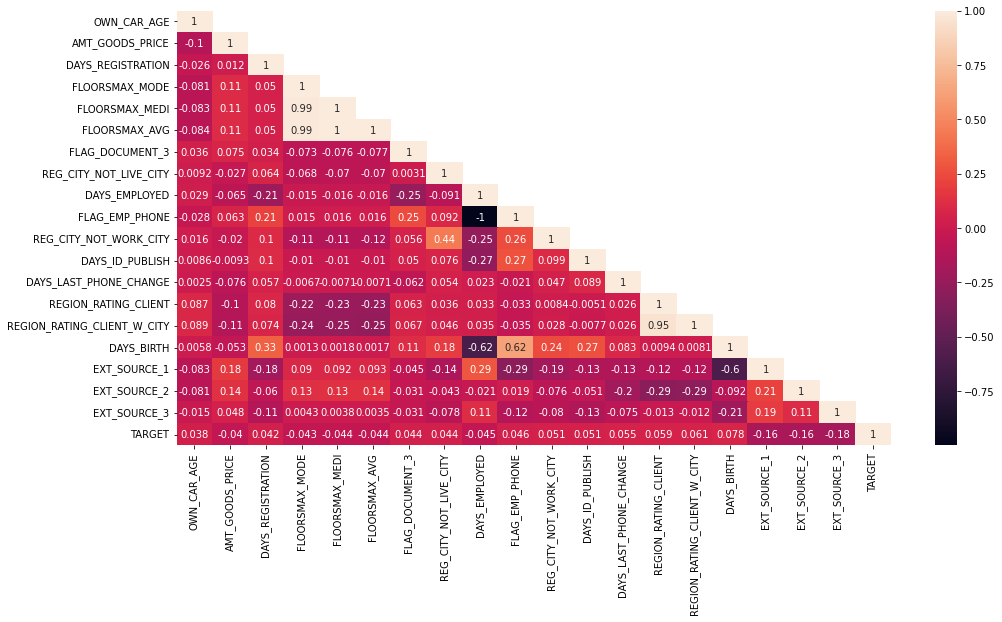

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
corr = app_train.corr()
cols = corr["TARGET"].sort_values(key=abs).tail(20).index
corr = corr.loc[cols, cols]
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
sns.heatmap(corr, mask=mask, annot=True)
plt.show()

For numeric features we see that there is almost no correlation between single features and defaulting, EXT features which are scores from outside sources are the most correlated.

In [ ]:
cat_coord = app_train.select_dtypes("object").columns.tolist()
cram = calc_cat_coor(app_train[cat_coord + ["TARGET"]])
cram["TARGET"].sort_values(key=abs).tail(10)

WALLSMATERIAL_MODE     0.029676
NAME_CONTRACT_TYPE     0.030811
NAME_HOUSING_TYPE      0.036764
NAME_FAMILY_STATUS     0.040316
CODE_GENDER            0.054680
NAME_EDUCATION_TYPE    0.057452
NAME_INCOME_TYPE       0.063660
ORGANIZATION_TYPE      0.071044
OCCUPATION_TYPE        0.081017
TARGET                 0.999978
Name: TARGET, dtype: float64

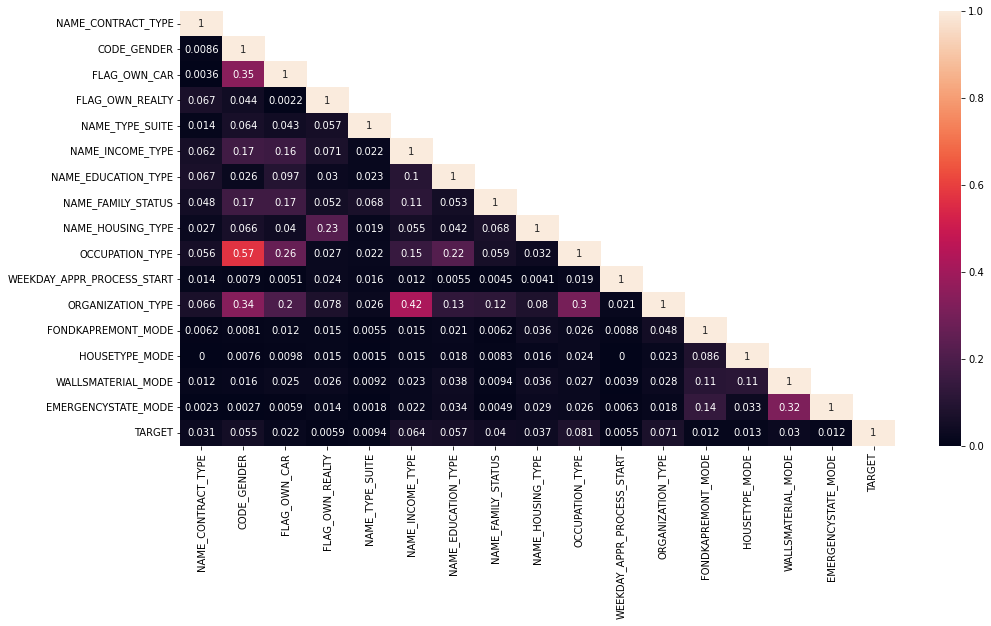

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
mask = np.zeros_like(cram)
mask[np.triu_indices_from(mask, k=1)] = True
sns.heatmap(cram, mask=mask, annot=True, ax=ax)
plt.show()

For categoric features occupation and organization types seem most important

## Numeric distributions

In [ ]:
app_train = app_train.drop(
    app_train["AMT_INCOME_TOTAL"].sort_values().tail(3).index, axis=0
)
app_train = app_train.drop(
    app_train.loc[app_train["CODE_GENDER"] == "XNA"].index, axis=0
)

Dropped 3 extreme income values.

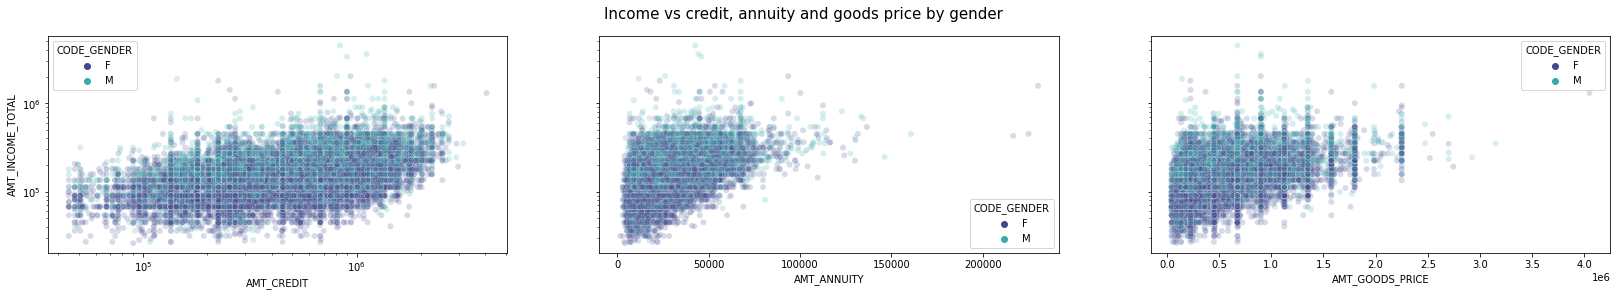

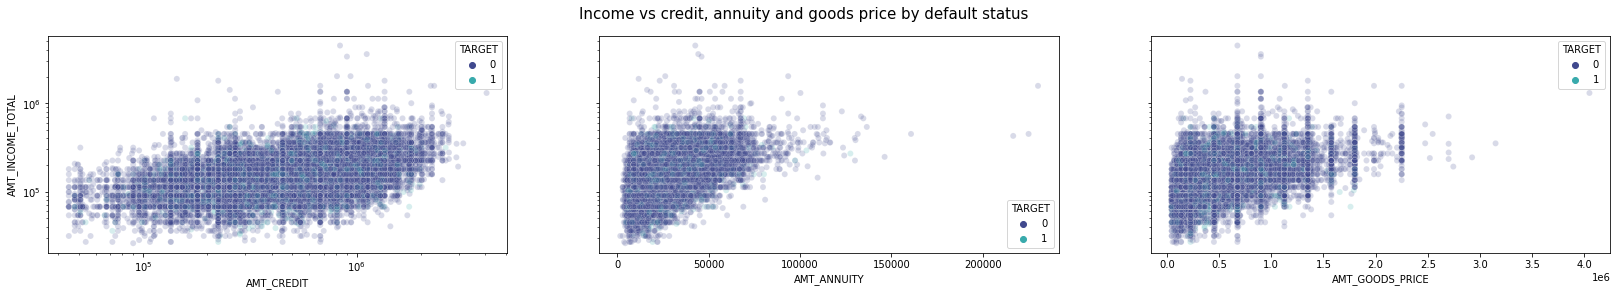

In [ ]:
sampled = app_train.sample(frac=0.1)
fig, axi = plt.subplots(1, 3, sharey=True, figsize=(28, 4))
ax = sns.scatterplot(
    data=sampled,
    y="AMT_INCOME_TOTAL",
    x="AMT_CREDIT",
    hue="CODE_GENDER",
    alpha=0.2,
    palette="mako",
    ax=axi[0],
)
ax.set_yscale("log")
ax.set_xscale("log")
ax = sns.scatterplot(
    data=sampled,
    y="AMT_INCOME_TOTAL",
    x="AMT_ANNUITY",
    hue="CODE_GENDER",
    alpha=0.2,
    palette="mako",
    ax=axi[1],
)
ax = sns.scatterplot(
    data=sampled,
    y="AMT_INCOME_TOTAL",
    x="AMT_GOODS_PRICE",
    hue="CODE_GENDER",
    alpha=0.2,
    palette="mako",
    ax=axi[2],
)
plt.suptitle("Income vs credit, annuity and goods price by gender", fontsize=15)

fig, axi = plt.subplots(1, 3, sharey=True, figsize=(28, 4))
ax = sns.scatterplot(
    data=sampled,
    y="AMT_INCOME_TOTAL",
    x="AMT_CREDIT",
    hue="TARGET",
    alpha=0.2,
    palette="mako",
    ax=axi[0],
)
ax.set_yscale("log")
ax.set_xscale("log")
ax = sns.scatterplot(
    data=sampled,
    y="AMT_INCOME_TOTAL",
    x="AMT_ANNUITY",
    hue="TARGET",
    alpha=0.2,
    palette="mako",
    ax=axi[1],
)
ax = sns.scatterplot(
    data=sampled,
    y="AMT_INCOME_TOTAL",
    x="AMT_GOODS_PRICE",
    hue="TARGET",
    alpha=0.2,
    palette="mako",
    ax=axi[2],
)
plt.suptitle("Income vs credit, annuity and goods price by default status", fontsize=15)
plt.show()

First I wanted to look at the loan parameters and if they are influenced by income of the person. 

One thing that we can notice is that females seem to be earning less than males. Also loan sizes and cost of purchases are increasing with persons income.  

For loan defaults I can't make out any patterns just looking at the charts.

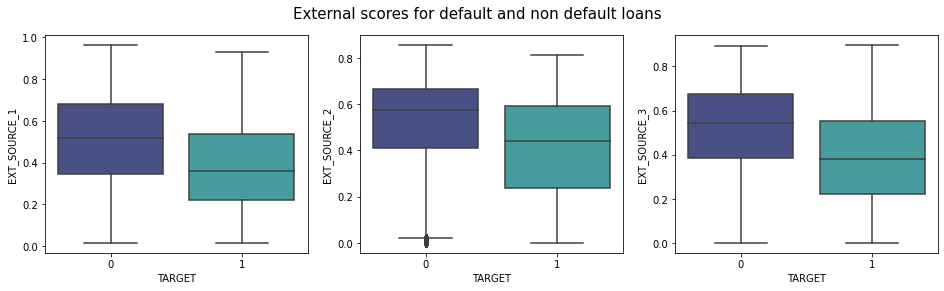

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for i in range(3):
    sns.boxplot(
        data=app_train, y=f"EXT_SOURCE_{i+1}", x="TARGET", palette="mako", ax=ax[i]
    )
plt.suptitle("External scores for default and non default loans", fontsize=15)
plt.show()

Low external sources scores are more likely to mean default as shown by the negative correlations they have with default. Still they are not conclusive by themselves.


Lets check if males are more likely to default than females


In [ ]:
male = app_train.loc[app_train.CODE_GENDER == "M"]["TARGET"]
female = app_train.loc[app_train.CODE_GENDER == "F"]["TARGET"]

In [ ]:
p_value, mean_diff, diffs = permute_p(male, female, n_perm=1000, alt="greater")
print(p_value)

0.0


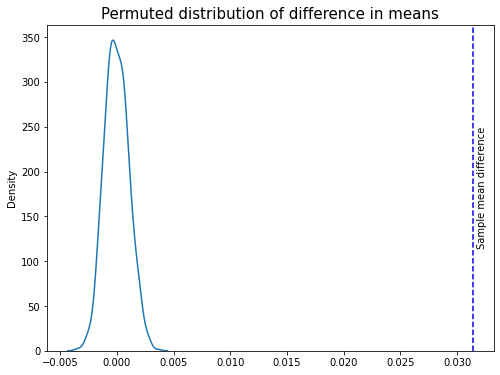

In [ ]:
plot_pvalue(diffs, mean_diff, p_value, alt="greater")

The difference in male and female default probabilities is minimal but because of the large number of samples the males are statistically more likely to default than females.

## Categorical data

In [ ]:
pcols = [
    "DAYS_BIRTH",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_INCOME_TYPE",
    "ORGANIZATION_TYPE",
    "OCCUPATION_TYPE",
    "TARGET",
]
personal = app_train[pcols].copy()
personal["DAYS_BIRTH"] = personal["DAYS_BIRTH"] // -365


def get_age(val):
    interval = (val // 5) * 5
    return f"{interval}-{interval + 4}"


personal["DAYS_BIRTH"] = personal["DAYS_BIRTH"].apply(get_age)
personal.sort_values("DAYS_BIRTH", inplace=True)

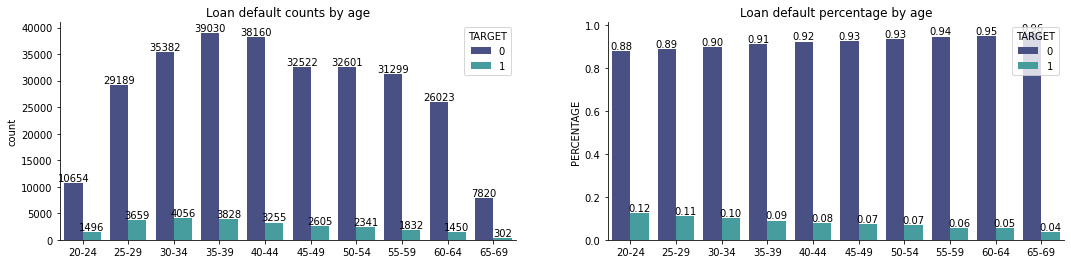

In [ ]:
fig, axi = plt.subplots(1, 2, figsize=(18, 4))

sns.countplot(x=personal.DAYS_BIRTH, hue=personal.TARGET, palette="mako", ax=axi[0])
vert_annot(axi[0])
axi[0].set_title("Loan default counts by age")
axi[0].set_xlabel("")

default = (
    personal.groupby("DAYS_BIRTH")["TARGET"].sum().sort_index()
    / personal["DAYS_BIRTH"].value_counts().sort_index()
)
no_default = 1 - default
perc = pd.DataFrame({1: default, 0: no_default})
perc = perc.stack().reset_index()
perc.columns = ["DAYS_BIRTH", "TARGET", "PERCENTAGE"]
sns.barplot(
    x=perc.DAYS_BIRTH, y=perc.PERCENTAGE, hue=perc.TARGET, palette="mako", ax=axi[1]
)
vert_annot(axi[1], 2)
axi[1].set_title("Loan default percentage by age")
axi[1].set_xlabel("")
sns.despine()
plt.show()

Percentage of people that default on loans decrease with age.

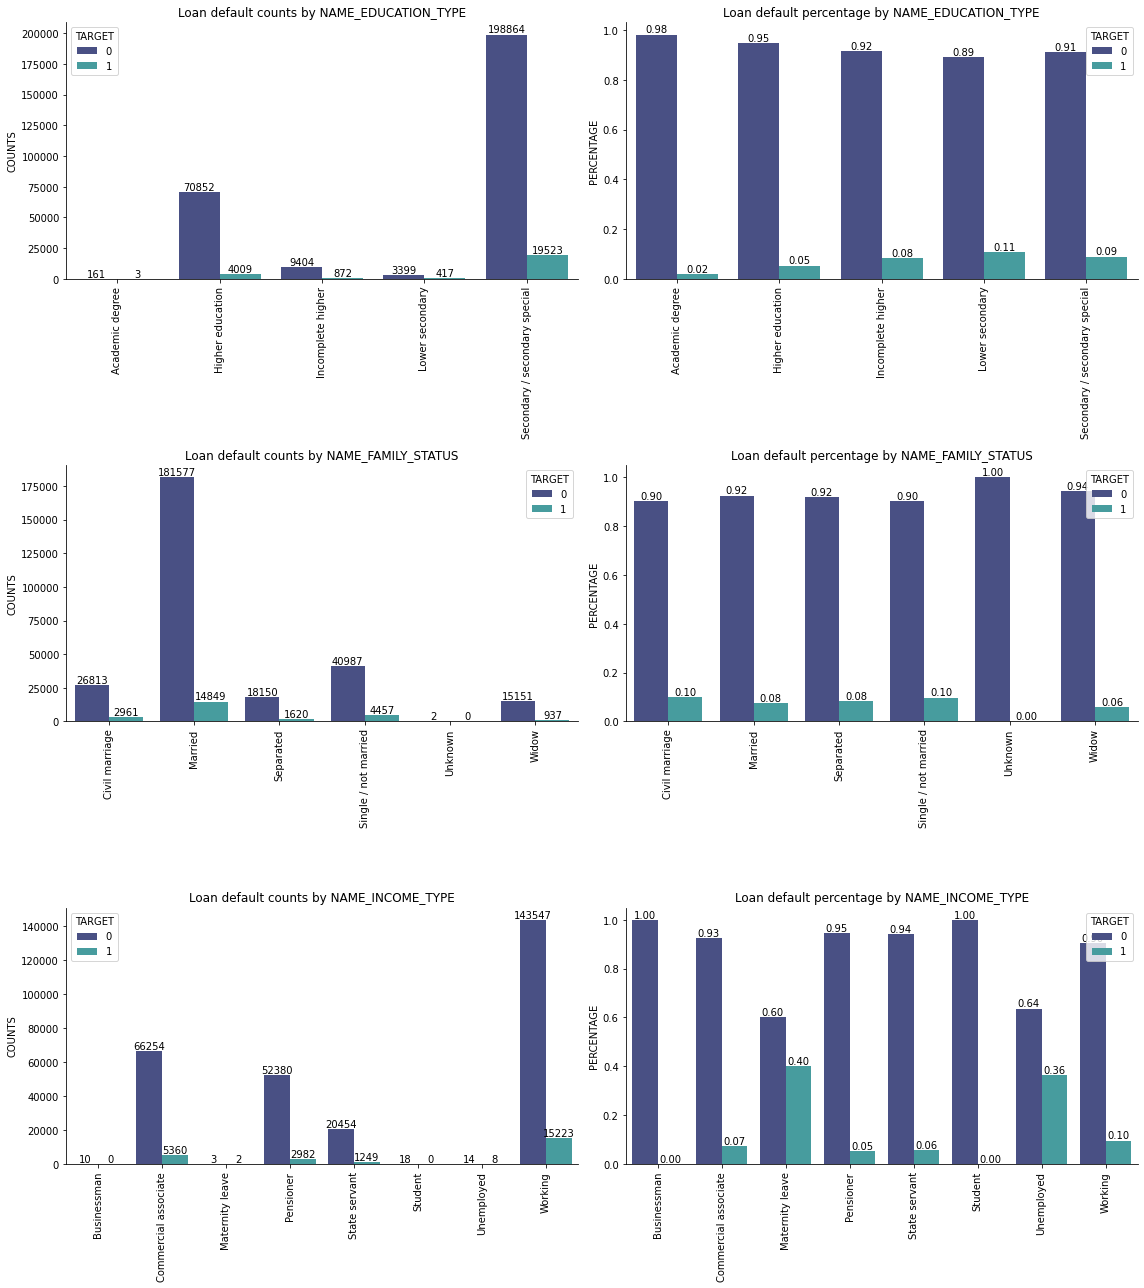

In [ ]:
cols = ["NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_INCOME_TYPE"]
fig, axi = plt.subplots(3, 2, figsize=(16, 18))
for i, ax in enumerate(axi):
    default = personal.groupby(cols[i])["TARGET"].sum().sort_index()
    no_default = personal[cols[i]].value_counts().sort_index() - default
    counts = pd.DataFrame({1: default, 0: no_default})
    counts = counts.stack().reset_index()
    counts.columns = [cols[i], "TARGET", "COUNTS"]
    sns.barplot(
        x=counts[cols[i]], y=counts.COUNTS, hue=counts.TARGET, palette="mako", ax=ax[0]
    )
    vert_annot(ax[0], 0)
    ax[0].set_title(f"Loan default counts by {cols[i]}")
    ax[0].set_xlabel("")
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

    default = (
        personal.groupby(cols[i])["TARGET"].sum().sort_index()
        / personal[cols[i]].value_counts().sort_index()
    )
    no_default = 1 - default
    perc = pd.DataFrame({1: default, 0: no_default})
    perc = perc.stack().reset_index()
    perc.columns = [cols[i], "TARGET", "PERCENTAGE"]
    sns.barplot(
        x=perc[cols[i]], y=perc.PERCENTAGE, hue=perc.TARGET, palette="mako", ax=ax[1]
    )
    vert_annot(ax[1], 2)
    ax[1].set_title(f"Loan default percentage by {cols[i]}")
    ax[1].set_xlabel("")
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    plt.tight_layout()

sns.despine()
plt.show()

No real differences for in default rates between these categories.

Most people taking out home credits have a secondary education are working and married.

## Data aggregations

For all tables except bureau and bureau balance I will aggregate them on SK_ID_CURR and do simple mean aggregations as well as count instances for previous credit card accounts and similar values.


In [ ]:
from typing import List


def agg_df(
    df: pd.DataFrame,
    agg_key: str,
    prefix: str,
    exclude: List[str] = [],
    num_trans: List[str] = ["mean"],
) -> pd.DataFrame:
    """
    Function that one hot encodes categorical data, then groups data by
    given key and performs aggregations
    """
    ori_cols = df.columns.values.tolist()
    exclude.append(agg_key)

    num_cols = df.select_dtypes(np.number).columns.values.tolist()
    num_agg = [col for col in num_cols if col not in exclude]

    cat_cols = df.select_dtypes("object").columns.values.tolist()
    cat_agg = [col for col in cat_cols if col not in exclude]

    df = pd.get_dummies(df, columns=cat_agg, dummy_na=True)
    oh_cols = [col for col in df.columns if col not in ori_cols]

    df_agg = {col: num_trans for col in num_agg}
    for col in oh_cols:
        df_agg[col] = ["mean"]
    df = df.groupby(agg_key).agg({**df_agg})
    df.columns = [prefix + "_" + i[0] + "_" + i[1] for i in df.columns]

    return df

In [ ]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
bb_agg = agg_df(df=bureau_balance, agg_key="SK_ID_BUREAU", prefix="bb")
bb_agg.drop("bb_STATUS_nan_mean", axis=1, inplace=True)

In [ ]:
bb_agg.head(2)

,bb_MONTHS_BALANCE_mean,bb_STATUS_0_mean,bb_STATUS_1_mean,bb_STATUS_2_mean,bb_STATUS_3_mean,bb_STATUS_4_mean,bb_STATUS_5_mean,bb_STATUS_C_mean,bb_STATUS_X_mean
SK_ID_BUREAU,,,,,,,,,
5001709,-48.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402
5001710,-41.0,0.060241,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446


In [ ]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
bureau.set_index("SK_ID_BUREAU", inplace=True)
b_num_cols = [
    col
    for col in bureau.select_dtypes(np.number).columns.tolist()
    if col != "SK_ID_CURR"
]
bureau = bureau.join(other=bb_agg, how="left")
b_ohe = [col for col in bureau.columns if col not in b_num_cols]

Adding features for currently active and already closed loans.

In [ ]:
b_act = bureau.loc[bureau.CREDIT_ACTIVE == "Active"]
b_act_count = b_act.groupby("SK_ID_CURR")["SK_ID_CURR"].count()
b_act_count.name = "b_act_count"
b_act = agg_df(b_act, agg_key="SK_ID_CURR", prefix="b_act", exclude=b_ohe)

b_cls = bureau.loc[bureau.CREDIT_ACTIVE == "Closed"]
b_cls_count = b_cls.groupby("SK_ID_CURR")["SK_ID_CURR"].count()
b_cls_count.name = "b_cls_count"
b_cls = agg_df(b_cls, agg_key="SK_ID_CURR", prefix="b_cls", exclude=b_ohe)

b_agg = agg_df(df=bureau, agg_key="SK_ID_CURR", prefix="b", exclude=["SK_ID_BUREAU"])
b_agg = b_agg.join([b_act, b_cls, b_act_count, b_cls_count])

In [49]:
b_agg.head(2)

,b_DAYS_CREDIT_mean,b_CREDIT_DAY_OVERDUE_mean,b_DAYS_CREDIT_ENDDATE_mean,b_DAYS_ENDDATE_FACT_mean,b_AMT_CREDIT_MAX_OVERDUE_mean,b_CNT_CREDIT_PROLONG_mean,b_AMT_CREDIT_SUM_mean,b_AMT_CREDIT_SUM_DEBT_mean,b_AMT_CREDIT_SUM_LIMIT_mean,b_AMT_CREDIT_SUM_OVERDUE_mean,...,b_cls_AMT_CREDIT_MAX_OVERDUE_mean,b_cls_CNT_CREDIT_PROLONG_mean,b_cls_AMT_CREDIT_SUM_mean,b_cls_AMT_CREDIT_SUM_DEBT_mean,b_cls_AMT_CREDIT_SUM_LIMIT_mean,b_cls_AMT_CREDIT_SUM_OVERDUE_mean,b_cls_DAYS_CREDIT_UPDATE_mean,b_cls_AMT_ANNUITY_mean,b_act_count,b_cls_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-735.0,0.0,82.428571,-825.5,NaN,0.0,207623.571429,85240.928571,0.00000,0.0,...,NaN,0.0,142335.0,0.0,0.0,0.0,-155.000000,0.0,3.0,4.0
100002,-874.0,0.0,-349.000000,-697.5,1681.029,0.0,108131.945625,49156.200000,7997.14125,0.0,...,2091.16125,0.0,63844.5,0.0,0.0,0.0,-661.333333,0.0,2.0,6.0


In [48]:
# joblib.dump(b_agg, '/content/drive/MyDrive/b_agg.dump')
b_agg = joblib.load("/content/drive/MyDrive/b_agg.dump")

In [ ]:
del bureau
del bureau_balance
gc.collect()

46087

In [ ]:
pos_cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
xna_pcb = pos_cash_balance.loc[pos_cash_balance.NAME_CONTRACT_STATUS == "XNA"].index
pos_cash_balance = pos_cash_balance.drop(xna_pcb)

pcb_agg = agg_df(
    df=pos_cash_balance, agg_key="SK_ID_CURR", prefix="pcb", exclude=["SK_ID_PREV"]
)
pcb_agg["pcb_count"] = pos_cash_balance.groupby("SK_ID_CURR")["SK_ID_PREV"].count()
pcb_agg.head(2)

,pcb_MONTHS_BALANCE_mean,pcb_CNT_INSTALMENT_mean,pcb_CNT_INSTALMENT_FUTURE_mean,pcb_SK_DPD_mean,pcb_SK_DPD_DEF_mean,pcb_NAME_CONTRACT_STATUS_Active_mean,pcb_NAME_CONTRACT_STATUS_Amortized debt_mean,pcb_NAME_CONTRACT_STATUS_Approved_mean,pcb_NAME_CONTRACT_STATUS_Canceled_mean,pcb_NAME_CONTRACT_STATUS_Completed_mean,pcb_NAME_CONTRACT_STATUS_Demand_mean,pcb_NAME_CONTRACT_STATUS_Returned to the store_mean,pcb_NAME_CONTRACT_STATUS_Signed_mean,pcb_NAME_CONTRACT_STATUS_nan_mean,pcb_count
SK_ID_CURR,,,,,,,,,,,,,,,
100001,-72.555556,4.0,1.444444,0.777778,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,9
100002,-10.000000,24.0,15.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,19


In [ ]:
# joblib.dump(pcb_agg, '/content/drive/MyDrive/pcb_agg.dump')
pcb_agg = joblib.load("/content/drive/MyDrive/pcb_agg.dump")

In [ ]:
del pos_cash_balance
gc.collect()

100

Adding features for late/early payments and difference between payment and amount owed.

In [ ]:
installments_payments["DAYS_LATE"] = (
    installments_payments["DAYS_ENTRY_PAYMENT"]
    - installments_payments["DAYS_INSTALMENT"]
)
installments_payments["DAYS_EARLY"] = (
    installments_payments["DAYS_INSTALMENT"]
    - installments_payments["DAYS_ENTRY_PAYMENT"]
)
installments_payments["PAY_DIFF"] = (
    installments_payments["AMT_PAYMENT"] - installments_payments["AMT_INSTALMENT"]
)

installments_payments["DAYS_LATE"] = np.where(
    installments_payments["DAYS_LATE"] > 0, installments_payments["DAYS_LATE"], 0
)
installments_payments["DAYS_EARLY"] = np.where(
    installments_payments["DAYS_EARLY"] > 0, installments_payments["DAYS_EARLY"], 0
)

In [ ]:
installments_payments.describe().style.format("{:.2f}")

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_LATE,DAYS_EARLY,PAY_DIFF
count,13605401.00,13605401.00,13605401.00,13605401.00,13605401.00,13602496.00,13605401.00,13602496.00,13605401.00,13605401.00,13602496.00
mean,1903364.97,278444.88,0.86,18.87,-1042.27,-1051.11,17050.91,17238.22,1.03,9.82,187.15
std,536202.91,102718.31,1.04,26.66,800.95,800.59,50570.25,54735.78,20.78,14.15,19106.73
min,1000001.00,100001.00,0.00,1.00,-2922.00,-4921.00,0.00,0.00,0.00,0.00,-2424726.41
25%,1434191.00,189639.00,0.00,4.00,-1654.00,-1662.00,4226.09,3398.26,0.00,0.00,0.00
50%,1896520.00,278685.00,1.00,8.00,-818.00,-827.00,8884.08,8125.52,0.00,6.00,0.00
75%,2369094.00,367530.00,1.00,19.00,-361.00,-370.00,16710.21,16108.42,0.00,14.00,0.00
max,2843499.00,456255.00,178.00,277.00,-1.00,-1.00,3771487.85,3771487.85,2884.00,3189.00,2630908.94


In [ ]:
ins_agg = agg_df(
    df=installments_payments,
    agg_key="SK_ID_CURR",
    prefix="ins",
    num_trans=["min", "max", "mean"],
    exclude=["SK_ID_PREV"],
)
ins_agg["ins_count"] = installments_payments.groupby("SK_ID_CURR")["SK_ID_PREV"].count()

In [ ]:
ins_agg.head(2)

,ins_NUM_INSTALMENT_VERSION_min,ins_NUM_INSTALMENT_VERSION_max,ins_NUM_INSTALMENT_VERSION_mean,ins_NUM_INSTALMENT_NUMBER_min,ins_NUM_INSTALMENT_NUMBER_max,ins_NUM_INSTALMENT_NUMBER_mean,ins_DAYS_INSTALMENT_min,ins_DAYS_INSTALMENT_max,ins_DAYS_INSTALMENT_mean,ins_DAYS_ENTRY_PAYMENT_min,...,ins_DAYS_LATE_min,ins_DAYS_LATE_max,ins_DAYS_LATE_mean,ins_DAYS_EARLY_min,ins_DAYS_EARLY_max,ins_DAYS_EARLY_mean,ins_PAY_DIFF_min,ins_PAY_DIFF_max,ins_PAY_DIFF_mean,ins_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1.0,2.0,1.142857,1,4,2.714286,-2916.0,-1619.0,-2187.714286,-2916.0,...,0.0,11.0,1.571429,0.0,36.0,8.857143,0.0,0.0,0.0,7
100002,1.0,2.0,1.052632,1,19,10.000000,-565.0,-25.0,-295.000000,-587.0,...,0.0,0.0,0.000000,12.0,31.0,20.421053,0.0,0.0,0.0,19


In [ ]:
# joblib.dump(ins_agg, '/content/drive/MyDrive/ins_agg.dump')
ins_agg = joblib.load("/content/drive/MyDrive/ins_agg.dump")

In [ ]:
cc_agg = agg_df(
    df=credit_card_balance,
    agg_key="SK_ID_CURR",
    prefix="cc",
    num_trans=["min", "max", "mean"],
    exclude=["SK_ID_PREV"],
)
cc_agg["cc_count"] = credit_card_balance.groupby("SK_ID_CURR")["SK_ID_PREV"].count()

In [ ]:
cc_agg.head(2)

,cc_MONTHS_BALANCE_min,cc_MONTHS_BALANCE_max,cc_MONTHS_BALANCE_mean,cc_AMT_BALANCE_min,cc_AMT_BALANCE_max,cc_AMT_BALANCE_mean,cc_AMT_CREDIT_LIMIT_ACTUAL_min,cc_AMT_CREDIT_LIMIT_ACTUAL_max,cc_AMT_CREDIT_LIMIT_ACTUAL_mean,cc_AMT_DRAWINGS_ATM_CURRENT_min,...,cc_SK_DPD_DEF_mean,cc_NAME_CONTRACT_STATUS_Active_mean,cc_NAME_CONTRACT_STATUS_Approved_mean,cc_NAME_CONTRACT_STATUS_Completed_mean,cc_NAME_CONTRACT_STATUS_Demand_mean,cc_NAME_CONTRACT_STATUS_Refused_mean,cc_NAME_CONTRACT_STATUS_Sent proposal_mean,cc_NAME_CONTRACT_STATUS_Signed_mean,cc_NAME_CONTRACT_STATUS_nan_mean,cc_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,0.0,0.0,0.000000,270000,270000,270000.000000,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
100011,-75,-2,-38.5,0.0,189000.0,54482.111149,90000,180000,164189.189189,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74


In [53]:
# joblib.dump(cc_agg, '/content/drive/MyDrive/cc_agg.dump')
cc_agg = joblib.load("/content/drive/MyDrive/cc_agg.dump")

In [ ]:
del installments_payments
del credit_card_balance
gc.collect()

50

In [ ]:
previous_applications.describe().style.format("{:.2f}")

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1670214.00,1670214.00,1297979.00,1670214.00,1670213.00,774370.00,1284699.00,1670214.00,1670214.00,774370.00,5951.00,5951.00,1670214.00,1670214.00,1297984.00,997149.00,997149.00,997149.00,997149.00,997149.00,997149.00
mean,1923089.14,278357.17,15955.12,175233.86,196114.02,6697.40,227847.28,12.48,1.00,0.08,0.19,0.77,-880.68,313.95,16.05,342209.86,13826.27,33767.77,76582.40,81992.34,0.33
std,532597.96,102814.82,14782.14,292779.76,318574.62,20921.50,315396.56,3.33,0.06,0.11,0.09,0.10,779.10,7127.44,14.57,88916.12,72444.87,106857.03,149647.42,153303.52,0.47
min,1000001.00,100001.00,0.00,0.00,0.00,-0.90,0.00,0.00,0.00,-0.00,0.03,0.37,-2922.00,-1.00,0.00,-2922.00,-2892.00,-2801.00,-2889.00,-2874.00,0.00
25%,1461857.25,189329.00,6321.78,18720.00,24160.50,0.00,50841.00,10.00,1.00,0.00,0.16,0.72,-1300.00,-1.00,6.00,365243.00,-1628.00,-1242.00,-1314.00,-1270.00,0.00
50%,1923110.50,278714.50,11250.00,71046.00,80541.00,1638.00,112320.00,12.00,1.00,0.05,0.19,0.84,-581.00,3.00,12.00,365243.00,-831.00,-361.00,-537.00,-499.00,0.00
75%,2384279.75,367514.00,20658.42,180360.00,216418.50,7740.00,234000.00,15.00,1.00,0.11,0.19,0.85,-280.00,82.00,24.00,365243.00,-411.00,129.00,-74.00,-44.00,1.00
max,2845382.00,456255.00,418058.15,6905160.00,6905160.00,3060045.00,6905160.00,23.00,1.00,1.00,1.00,1.00,-1.00,4000000.00,84.00,365243.00,365243.00,365243.00,365243.00,365243.00,1.00


Removing weird values for days.

In [ ]:
previous_applications["DAYS_FIRST_DRAWING"].replace(365243, np.nan, inplace=True)
previous_applications["DAYS_FIRST_DUE"].replace(365243, np.nan, inplace=True)
previous_applications["DAYS_LAST_DUE_1ST_VERSION"].replace(365243, np.nan, inplace=True)
previous_applications["DAYS_LAST_DUE"].replace(365243, np.nan, inplace=True)
previous_applications["DAYS_TERMINATION"].replace(365243, np.nan, inplace=True)

In [ ]:
previous_applications.NAME_CONTRACT_STATUS.value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

Most previous applications were approved.

In [ ]:
previous_applications["prev_pay_rate"] = (
    previous_applications["AMT_ANNUITY"] / previous_applications["AMT_CREDIT"]
)
prev_app = agg_df(
    df=previous_applications,
    agg_key="SK_ID_CURR",
    prefix="prev",
    num_trans=["min", "max", "mean"],
    exclude=["SK_ID_PREV"],
)
prev_app["prev_app_count"] = previous_applications.groupby("SK_ID_CURR")[
    "SK_ID_PREV"
].count()

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Again adding features for approved, canceled, refused loans.

In [ ]:
num_feats = previous_applications.select_dtypes(np.number).columns.tolist()
prev_acc = agg_df(
    previous_applications.loc[
        previous_applications.NAME_CONTRACT_STATUS == "Approved", num_feats
    ],
    agg_key="SK_ID_CURR",
    prefix="prev_acc",
    exclude=["SK_ID_PREV"],
)
prev_canc = agg_df(
    previous_applications.loc[
        previous_applications.NAME_CONTRACT_STATUS == "Canceled", num_feats
    ],
    agg_key="SK_ID_CURR",
    prefix="prev_canc",
    exclude=["SK_ID_PREV"],
)
prev_rej = agg_df(
    previous_applications.loc[
        previous_applications.NAME_CONTRACT_STATUS == "Refused", num_feats
    ],
    agg_key="SK_ID_CURR",
    prefix="prev_rej",
    exclude=["SK_ID_PREV"],
)

In [ ]:
prev_app = prev_app.join([prev_acc, prev_canc, prev_rej], how="left")
prev_app.head(2)

,prev_AMT_ANNUITY_min,prev_AMT_ANNUITY_max,prev_AMT_ANNUITY_mean,prev_AMT_APPLICATION_min,prev_AMT_APPLICATION_max,prev_AMT_APPLICATION_mean,prev_AMT_CREDIT_min,prev_AMT_CREDIT_max,prev_AMT_CREDIT_mean,prev_AMT_DOWN_PAYMENT_min,...,prev_rej_DAYS_DECISION_mean,prev_rej_SELLERPLACE_AREA_mean,prev_rej_CNT_PAYMENT_mean,prev_rej_DAYS_FIRST_DRAWING_mean,prev_rej_DAYS_FIRST_DUE_mean,prev_rej_DAYS_LAST_DUE_1ST_VERSION_mean,prev_rej_DAYS_LAST_DUE_mean,prev_rej_DAYS_TERMINATION_mean,prev_rej_NFLAG_INSURED_ON_APPROVAL_mean,prev_rej_prev_pay_rate_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000,24835.5,24835.5,24835.5,23787.0,23787.0,23787.0,2520.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,9251.775,9251.775,9251.775,179055.0,179055.0,179055.0,179055.0,179055.0,179055.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# joblib.dump(prev_app, '/content/drive/MyDrive/prev_app.dump')
prev_app = joblib.load("/content/drive/MyDrive/prev_app.dump")

In [ ]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Adding various ratios for current loans

In [ ]:
app_test["TARGET"] = np.array([np.nan] * app_test.shape[0])
curr_app = pd.concat([app_train, app_test], axis=0)
curr_app["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)
curr_app["dti"] = curr_app["AMT_CREDIT"] / curr_app["AMT_INCOME_TOTAL"]
curr_app["goods_price_to_income"] = (
    curr_app["AMT_GOODS_PRICE"] / curr_app["AMT_INCOME_TOTAL"]
)
curr_app["good_price_to_credit"] = curr_app["AMT_GOODS_PRICE"] / curr_app["AMT_CREDIT"]
curr_app["goods_price_to_annuity"] = (
    curr_app["AMT_GOODS_PRICE"] / curr_app["AMT_ANNUITY"]
)
curr_app["inc_per_person"] = curr_app["AMT_INCOME_TOTAL"] / curr_app["CNT_FAM_MEMBERS"]
curr_app["pay_rate"] = curr_app["AMT_ANNUITY"] / curr_app["AMT_CREDIT"]

Combining into a single dataset

In [ ]:
curr_app = curr_app.join(other=prev_app, on="SK_ID_CURR", how="left")
del prev_app
gc.collect()
curr_app = curr_app.join(other=b_agg, on="SK_ID_CURR", how="left")
del b_agg
gc.collect()
curr_app = curr_app.join(other=pcb_agg, on="SK_ID_CURR", how="left")
del pcb_agg
gc.collect()
curr_app = curr_app.join(other=cc_agg, on="SK_ID_CURR", how="left")
del cc_agg
gc.collect()
curr_app = curr_app.join(other=ins_agg, on="SK_ID_CURR", how="left")
del ins_agg
gc.collect()

0

In [ ]:
import re

cat_cols = curr_app.select_dtypes("object").columns
cat_enc = {}
for col in cat_cols:
    curr_app[col], values = pd.factorize(curr_app[col])
    cat_enc[col] = values
curr_app = curr_app.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "_", x))

In [ ]:
curr_app.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ins_DAYS_LATE_min,ins_DAYS_LATE_max,ins_DAYS_LATE_mean,ins_DAYS_EARLY_min,ins_DAYS_EARLY_max,ins_DAYS_EARLY_mean,ins_PAY_DIFF_min,ins_PAY_DIFF_max,ins_PAY_DIFF_mean,ins_count
0,100002,1.0,0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,100001,NaN,0,1,0,0,0,135000.0,568800.0,20560.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# joblib.dump(curr_app, '/content/drive/MyDrive/curr_app.dump')
curr_app = joblib.load("/content/drive/MyDrive/curr_app.dump")

Removing features with more than 80% missing values

In [75]:
curr_app.drop(
    curr_app.loc[:, curr_app.isna().mean() >= 0.8].columns, axis=1, inplace=True
)

In [76]:
test = curr_app.loc[curr_app["TARGET"].isna()].drop(["TARGET"], axis=1).copy()
X = curr_app.loc[curr_app["TARGET"].notna()].drop(["SK_ID_CURR"], axis=1).copy()
X.head(1)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ins_DAYS_LATE_min,ins_DAYS_LATE_max,ins_DAYS_LATE_mean,ins_DAYS_EARLY_min,ins_DAYS_EARLY_max,ins_DAYS_EARLY_mean,ins_PAY_DIFF_min,ins_PAY_DIFF_max,ins_PAY_DIFF_mean,ins_count
0,1.0,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
del curr_app
gc.collect()

53

# Default/payment difficulty prediction

Because the dataset contains many missing values I will use only gradient boosting algorithms, as they can deal with missing values, treating them as another class

In [12]:
y = X.TARGET.copy()
X.drop("TARGET", axis=1, inplace=True)

In [13]:
y.value_counts() / y.shape[0]

0.0    0.919273
1.0    0.080727
Name: TARGET, dtype: float64

The dataset is highly imbalanced

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_recall_curve,
    roc_curve,
    average_precision_score,
    classification_report,
)
from lightgbm import LGBMClassifier, early_stopping
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

In [15]:
from sklearn.metrics import f1_score
import optuna
import sqlite3
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(
    X_train, y_train, stratify=y_train, random_state=42
)

In [17]:
from sklearn.model_selection import cross_val_score


def get_baseline_model_performance(models, X, y, scoring="roc_auc"):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for model in models:
        print(f"Fiting {model}")
        result = cross_val_score(model, X, y, scoring=scoring, cv=cv)
        scores.append(result)
    return scores

In [18]:
from sklearn.metrics import confusion_matrix
from typing import Callable


class BaselineModelCV:
    """
    Helper for plotting CV xgboost, lightgbm and catboost metrics

    Args:
      X: features for models
      y: true values
    """

    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
        self.train_cm = []
        self.test_cm = []
        self.tpr = []
        self.fpr = []
        self.auc = []
        self.precision = []
        self.recall = []
        self.ap = []
        self.proba = []
        self.real = []

    def fit(self, model: Callable, folds: int, **kwargs) -> None:
        """
        Trains model on specified folds and adds calculated metrics

        Args:
          model: either xgboost, lightgbm or catboost model
          folds: number of folds to use
          kwargs: parameters for model fitting
        """

        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
        for idx, (train_idx, test_idx) in enumerate(cv.split(self.X, self.y)):
            X_train, X_test = self.X.iloc[train_idx], self.X.iloc[test_idx]
            y_train, y_test = self.y.iloc[train_idx], self.y.iloc[test_idx]
            X_train, X_eval, y_train, y_eval = train_test_split(
                X_train, y_train, stratify=y_train, random_state=42
            )
            _ = model.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], **kwargs)

            proba = model.predict_proba(X_test)[:, 1]
            self.proba.append(proba)
            self.real.append(y_test)

            self.train_cm.append(confusion_matrix(y_train, model.predict(X_train)))
            self.test_cm.append(confusion_matrix(y_test, model.predict(X_test)))

            fpr, tpr, _ = roc_curve(y_test, proba)
            self.fpr.append(fpr)
            self.tpr.append(tpr)
            self.auc.append(roc_auc_score(y_test, proba))

            precision, recall, _ = precision_recall_curve(y_test, proba)
            self.precision.append(precision)
            self.recall.append(recall)
            self.ap.append(average_precision_score(y_test, proba))

    def plot_cm(self, train: bool, ax: plt.axes) -> None:
        """
        Plots confusion matrix with mean and std values

        Args:
          train: flag to use train or test value
          ax: axis on which to draw the plot
        """

        cm = self.train_cm if train else self.test_cm
        title = "Training" if train else "Testing"
        means = np.mean(cm, axis=0)
        stds = np.std(cm, axis=0)
        n_class = means.shape[1]

        im_ = ax.imshow(means)
        display_labels = np.arange(n_class)
        ax.set(
            xticks=np.arange(n_class),
            yticks=np.arange(n_class),
            xticklabels=display_labels,
            yticklabels=display_labels,
            ylabel="True label",
            xlabel="Predicted label",
            title=f"{title} confusion matrix",
        )

        cmap_min, cmap_max = im_.cmap(0), im_.cmap(1.0)
        thresh = (means.max() + means.min()) / 2.0
        for i in range(n_class):
            for j in range(n_class):
                text_cm = f"{means[i, j]:.0f} ± {stds[i, j]:.2f}"
                color = cmap_max if means[i, j] < thresh else cmap_min
                ax.text(j, i, text_cm, ha="center", va="center", color=color)

    def plot_roc_auc(self, ax: plt.axes):
        """
        Plot roc_auc curve for test data

        Args:
          ax: axis on which to plot
        """

        for idx in range(len(self.tpr)):
            ax.plot(
                self.fpr[idx],
                self.tpr[idx],
                label=f"Fold {idx + 1} ROC (AUC = {self.auc[idx]:.3f})",
                lw=1,
                alpha=0.3,
            )

        mean_fpr = np.linspace(0, 1, 1000)
        # interpolate tpr because its length can be different between folds
        interp_tpr = [
            np.interp(mean_fpr, self.fpr[idx], self.tpr[idx])
            for idx in range(len(self.tpr))
        ]
        mean_tpr = np.mean(interp_tpr, axis=0)
        mean_auc = np.mean(self.auc)
        std_auc = np.std(self.auc)
        ax.plot(
            mean_fpr,
            mean_tpr,
            color="b",
            label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
            lw=2,
        )

        ax.plot(
            [0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8
        )
        ax.legend(loc="lower right")
        ax.set_title("Testing ROC AUC curve")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")

    def plot_pr(self, ax: plt.axes):
        """
        Plot precision recall curve

        Args:
          ax: matplotlib.pyplot.axes object on which to plot
        """

        for idx in range(len(self.precision)):
            ax.plot(
                self.recall[idx],
                self.precision[idx],
                label=f"Fold {idx} PR (AP = {self.ap[idx]:.3f})",
                lw=1,
                alpha=0.3,
            )

        # interpolation doesn't work, so using micro average
        real = np.concatenate(self.real)
        proba = np.concatenate(self.proba)
        mean_avg_precision = np.mean(self.ap)
        std_avg_precision = np.std(self.ap)
        precision, recall, _ = precision_recall_curve(real, proba)
        ax.plot(
            recall,
            precision,
            color="b",
            label=f"Mean PR (AP = {mean_avg_precision:.3f} ± {std_avg_precision:.3f})",
            lw=2,
        )

        chance = len(self.y.loc[self.y == 1]) / len(self.y)
        ax.plot(
            [0, 1],
            [chance, chance],
            linestyle="--",
            lw=2,
            color="r",
            label="Chance",
            alpha=0.8,
        )
        ax.legend(loc="upper right")
        ax.set_title("Testing PR curve")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")

In [19]:
def plot_baseline_metrics(
    model: BaselineModelCV,
    size: tuple = (20, 4),
    title: str = "",
) -> None:
    """
    Plots cm, auc and pr curves from fitted ModelBaselineCV instance
    """

    fig, ax = plt.subplots(
        1, 4, figsize=size, gridspec_kw={"width_ratios": [1, 1, 2, 2]}
    )
    model.plot_cm(True, ax=ax[0])
    model.plot_cm(False, ax=ax[1])
    model.plot_roc_auc(ax=ax[2])
    model.plot_pr(ax=ax[3])
    plt.suptitle(title, fontsize=15, y=1.05)
    plt.tight_layout()

## Baseline models

In [ ]:
%%capture
lgbm_baseline = BaselineModelCV(X, y)
lgbm_baseline.fit(
    LGBMClassifier(device="gpu"),
    folds=5,
    callbacks=[early_stopping(50, verbose=False)],
    eval_metric="auc",
)
xgb_baseline = BaselineModelCV(X, y)
xgb_baseline.fit(
    XGBClassifier(tree_method="gpu_hist"),
    folds=5,
    eval_metric="auc",
    early_stopping_rounds=50,
    verbose=False,
)
ctb_baseline = BaselineModelCV(X, y)
ctb_baseline.fit(
    CatBoostClassifier(task_type="GPU", eval_metric="AUC"),
    folds=5,
    early_stopping_rounds=50,
    silent=True,
)

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


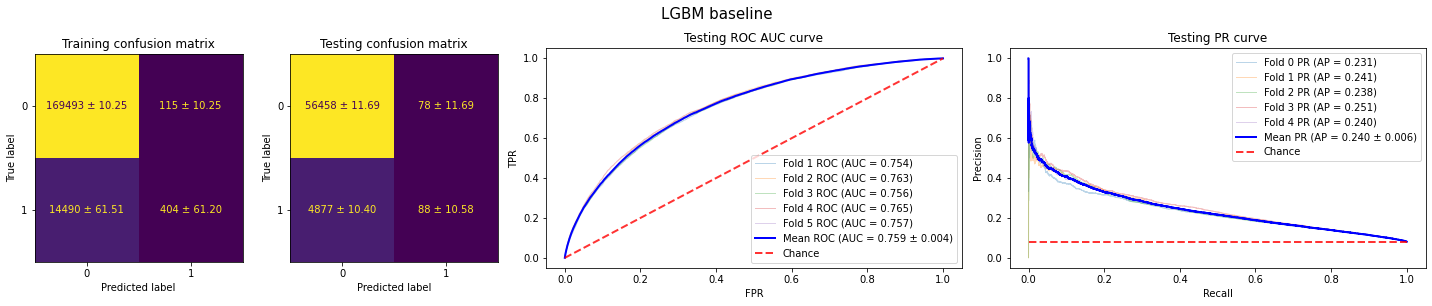

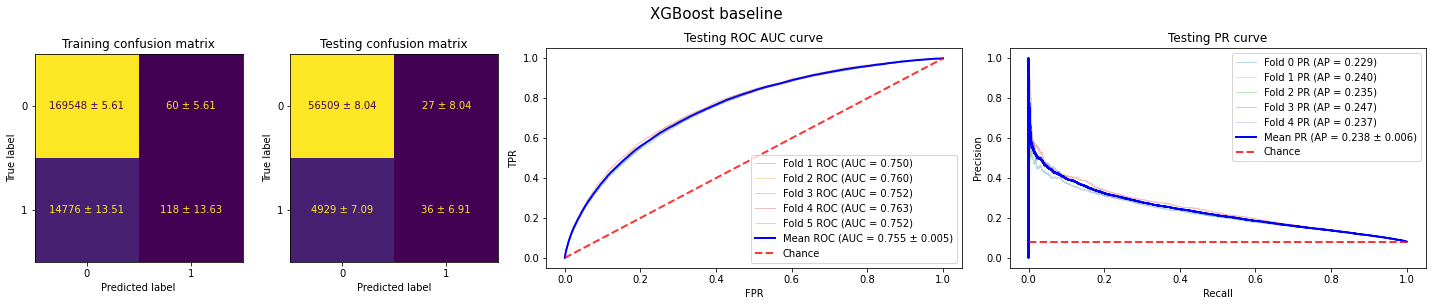

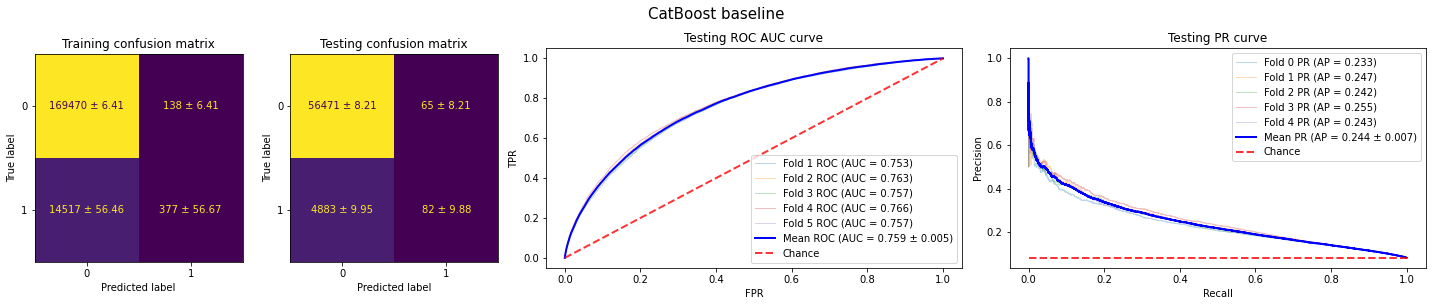

In [ ]:
plot_baseline_metrics(lgbm_baseline, title="LGBM baseline")
plot_baseline_metrics(xgb_baseline, title="XGBoost baseline")
plot_baseline_metrics(ctb_baseline, title="CatBoost baseline")

From initial baseline models CatBoost seems to perform the best judging by the confusion matrix and average precision scores.  
LGMB has similar recall but a lower precision.  
XGBoost seems to perform the worst overall.

## Feature importances

In [ ]:
%%capture
lgbm = LGBMClassifier(device="gpu")
lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_eval, y_eval)],
    callbacks=[early_stopping(50, verbose=False)],
    eval_metric="auc",
)

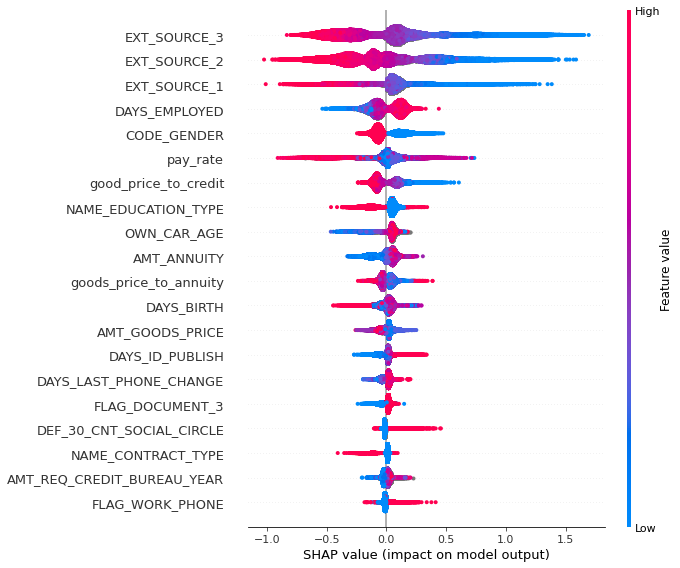

In [ ]:
lgbm_feat = pd.DataFrame(
    data=lgbm.feature_importances_, index=X_train.columns, columns=["imp"]
).sort_values("imp", ascending=False)
col_lgbm = lgbm_feat.loc[lgbm_feat.imp > 0].index

lgbm_explainer = shap.TreeExplainer(lgbm)
lgbm_shap_values = lgbm_explainer(X_train.values)
shap.summary_plot(lgbm_shap_values[:, :, 1], feature_names=X_train.columns)

EXT sources do seem to be the most important for predicting default. Interestingly gender also seems to play a clear role in this, males which are encoded as zero are more likely to default on loans. Various engineered ratios also seem to relevant, but only features from the current loan application appear in the top.  

Also out of 470 features only 301 had impact on the decision.

In [ ]:
len(col_lgbm)

301

In [ ]:
%%capture
xgbc = XGBClassifier()
xgbc.fit(
    X_train,
    y_train,
    eval_set=[(X_eval, y_eval)],
    eval_metric="auc",
    early_stopping_rounds=50,
    verbose=False,
)

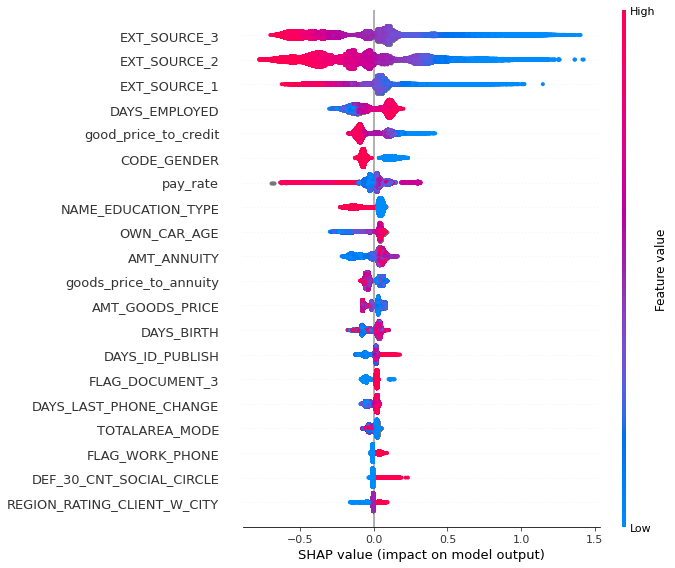

In [ ]:
xgb_feat = pd.DataFrame(
    data=xgbc.feature_importances_, index=X_train.columns, columns=["imp"]
).sort_values("imp", ascending=False)
col_xgb = xgb_feat.loc[xgb_feat.imp > 0].index

xgbc_explainer = shap.TreeExplainer(xgbc)
xgbc_shap_values = xgbc_explainer(X_train.values)
shap.summary_plot(xgbc_shap_values, feature_names=X_train.columns)

XGBoost is similar with feature importances to lgbm, it also says males are more likely to default and in this case only 92 features were important.

In [ ]:
len(col_xgb)

92

In [ ]:
%%capture
ctb = CatBoostClassifier(task_type="GPU")

train_data = Pool(
    data=X_train,
    label=y_train,
)
eval_data = Pool(
    data=X_eval,
    label=y_eval,
)

ctb.fit(
    train_data,
    eval_set=[eval_data],
    early_stopping_rounds=50,
    verbose=500,
)

Learning rate set to 0.045951
0:	learn: 0.6433784	test: 0.6432384	best: 0.6432384 (0)	total: 15.5ms	remaining: 15.5s
500:	learn: 0.2399083	test: 0.2459173	best: 0.2459173 (500)	total: 5.65s	remaining: 5.63s
999:	learn: 0.2323896	test: 0.2452667	best: 0.2452509 (971)	total: 11.2s	remaining: 0us
bestTest = 0.2452508748
bestIteration = 971
Shrink model to first 972 iterations.


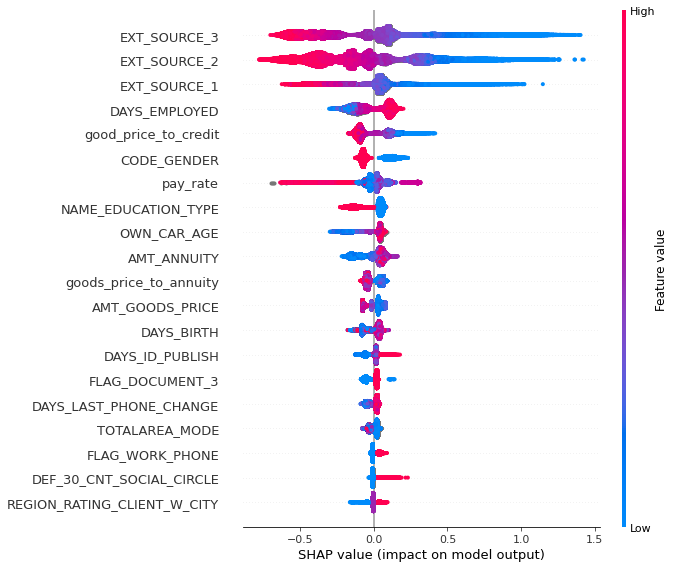

In [ ]:
ctb_feat = pd.DataFrame(
    data=ctb.feature_importances_, index=X_train.columns, columns=["imp"]
).sort_values("imp", ascending=False)
col_ctb = ctb_feat.loc[ctb_feat.imp > 0].index

ctb_explainer = shap.TreeExplainer(ctb)
ctb_shap_values = ctb_explainer(X_train.values)
shap.summary_plot(xgbc_shap_values, feature_names=X_train.columns)

Again the same with catboost, just here 442 features were important

In [ ]:
len(col_ctb)

442

## Baseline models only with important features

In [ ]:
%%capture
lgbm_baseline = BaselineModelCV(X[col_lgbm], y)
lgbm_baseline.fit(
    LGBMClassifier(device="gpu"),
    folds=5,
    callbacks=[early_stopping(100, verbose=False)],
    eval_metric="auc",
)
xgb_baseline = BaselineModelCV(X[col_xgb], y)
xgb_baseline.fit(
    XGBClassifier(tree_method="gpu_hist"),
    folds=5,
    eval_metric="auc",
    early_stopping_rounds=100,
    verbose=False,
)
ctb_baseline = BaselineModelCV(X[col_ctb], y)
ctb_baseline.fit(
    CatBoostClassifier(task_type="GPU", eval_metric="AUC"),
    folds=5,
    early_stopping_rounds=100,
    silent=True,
)

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


Because a lot of features seemed not to be important I again performed baseline measurements but only with features that were relevant, this did not decrease the models performance, in lgbm case it even improved it a bit looking at the confusion matrix.

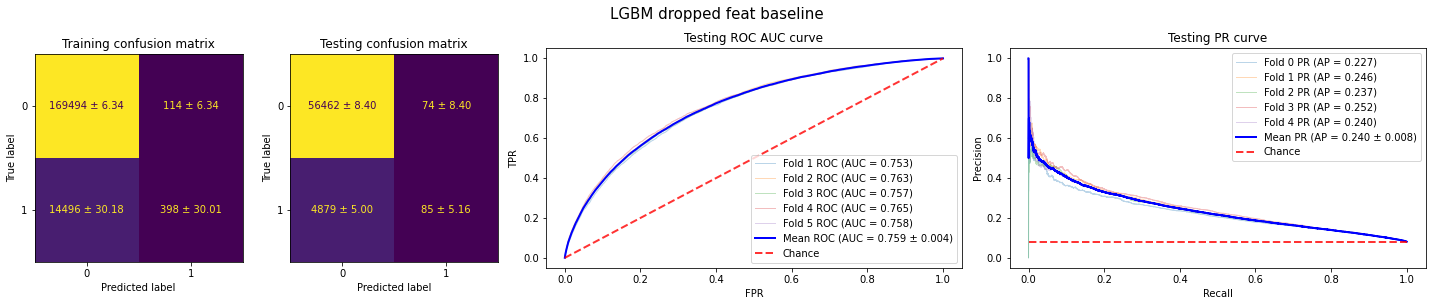

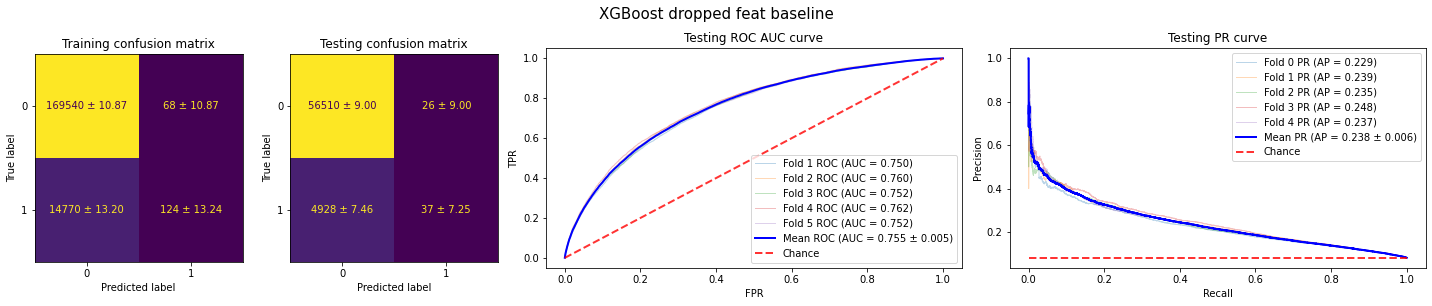

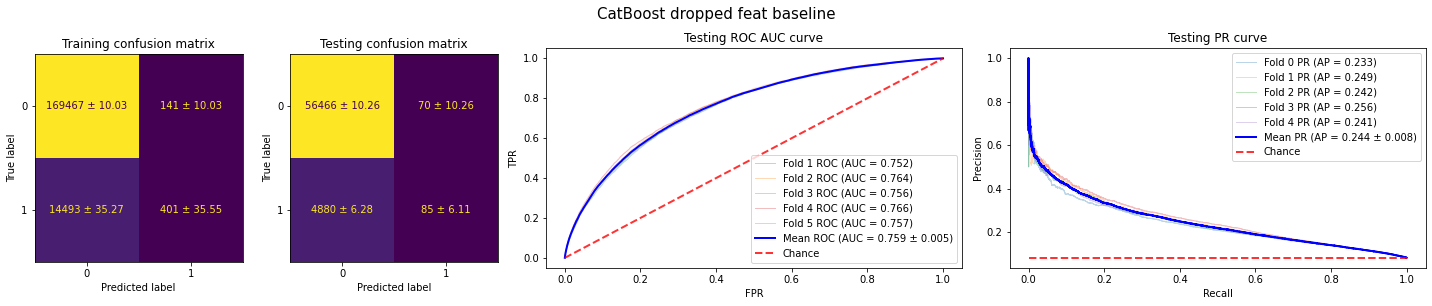

In [ ]:
plot_baseline_metrics(lgbm_baseline, title="LGBM dropped feat baseline")
plot_baseline_metrics(xgb_baseline, title="XGBoost dropped feat baseline")
plot_baseline_metrics(ctb_baseline, title="CatBoost dropped feat baseline")

In [ ]:
# joblib.dump(col_lgbm, '/content/drive/MyDrive/col_lgbm.dump')
col_lgbm = joblib.load("/content/drive/MyDrive/col_lgbm.dump")
# joblib.dump(col_xgb, '/content/drive/MyDrive/col_xgb.dump')
col_xgb = joblib.load("/content/drive/MyDrive/col_xgb.dump")
# joblib.dump(col_ctb, '/content/drive/MyDrive/col_ctb.dump')
col_ctb = joblib.load("/content/drive/MyDrive/col_ctb.dump")

In [ ]:
from probatus.feature_elimination import EarlyStoppingShapRFECV

In [ ]:
rfec_lgbm = LGBMClassifier(device="gpu")
shap_elimination = EarlyStoppingShapRFECV(
    clf=rfec_lgbm, step=0.3, cv=3, scoring="roc_auc", early_stopping_rounds=100
)
report = shap_elimination.fit_compute(X_train, y_train, check_additivity=False)

In [23]:
# joblib.dump(shap_elimination, '/content/drive/MyDrive/shap_elimination.dump')
# joblib.dump(report, '/content/drive/MyDrive/shap_elimination_report.dump')
shap_elimination = joblib.load("/content/drive/MyDrive/shap_elimination.dump")
report = joblib.load("/content/drive/MyDrive/shap_elimination_report.dump")

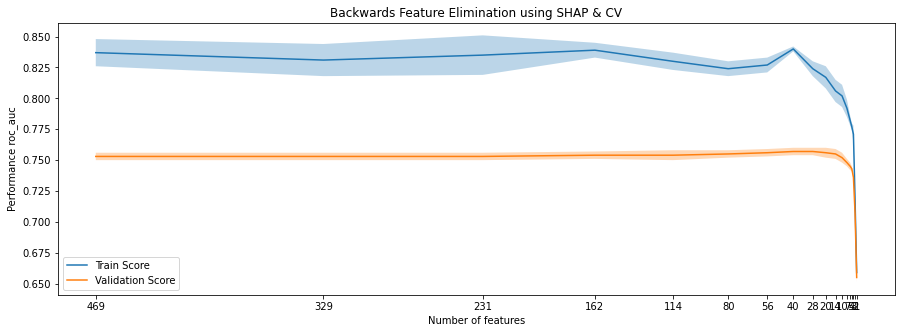

In [24]:
perf_plot = shap_elimination.plot(figsize=(15, 5))

In [25]:
report

,num_features,features_set,eliminated_features,train_metric_mean,train_metric_std,val_metric_mean,val_metric_std
1,469,"[NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR...","[ins_DAYS_EARLY_min, prev_NFLAG_LAST_APPL_IN_D...",0.837,0.011,0.753,0.003
2,329,"[NAME_CONTRACT_TYPE, prev_acc_AMT_APPLICATION_...",[prev_NAME_GOODS_CATEGORY_Office_Appliances_me...,0.831,0.013,0.753,0.003
3,231,"[prev_acc_RATE_DOWN_PAYMENT_mean, pcb_MONTHS_B...","[YEARS_BUILD_MEDI, prev_AMT_GOODS_PRICE_max, p...",0.835,0.016,0.753,0.003
4,162,"[pcb_MONTHS_BALANCE_mean, NAME_CONTRACT_TYPE, ...","[b_DAYS_CREDIT_UPDATE_mean, b_cls_AMT_CREDIT_M...",0.839,0.006,0.754,0.003
5,114,"[pcb_MONTHS_BALANCE_mean, NAME_CONTRACT_TYPE, ...","[prev_canc_HOUR_APPR_PROCESS_START_mean, ins_D...",0.830,0.007,0.754,0.004
6,80,"[NAME_CONTRACT_TYPE, pay_rate, prev_acc_AMT_AP...","[prev_RATE_DOWN_PAYMENT_mean, ins_PAY_DIFF_mea...",0.824,0.006,0.755,0.003
7,56,"[NAME_CONTRACT_TYPE, pay_rate, b_act_DAYS_CRED...","[b_cls_DAYS_CREDIT_UPDATE_mean, REG_CITY_NOT_L...",0.827,0.006,0.756,0.003
8,40,"[NAME_CONTRACT_TYPE, pay_rate, AMT_GOODS_PRICE...","[TOTALAREA_MODE, ORGANIZATION_TYPE, inc_per_pe...",0.840,0.002,0.757,0.003
9,28,"[NAME_CONTRACT_TYPE, pay_rate, AMT_GOODS_PRICE...","[AMT_CREDIT, dti, NAME_CONTRACT_TYPE, FLAG_WOR...",0.824,0.006,0.757,0.003
10,20,"[pay_rate, AMT_GOODS_PRICE, AMT_REQ_CREDIT_BUR...","[YEARS_BEGINEXPLUATATION_MEDI, FLAG_DOCUMENT_3...",0.817,0.009,0.756,0.004


Trying out dropping features based on SHAP score, only doing this with the lgbm model because even on gpu it took a couple of hours.

Results show that the model still performs well with only 40 features.

In [26]:
rfec_col = report.loc[8, "features_set"]

In [ ]:
rfec_col

['NAME_CONTRACT_TYPE',
 'pay_rate',
 'AMT_GOODS_PRICE',
 'prev_AMT_DOWN_PAYMENT_max',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'goods_price_to_annuity',
 'prev_DAYS_LAST_DUE_max',
 'TOTALAREA_MODE',
 'REGION_RATING_CLIENT_W_CITY',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'REGION_POPULATION_RELATIVE',
 'CODE_GENDER',
 'WALLSMATERIAL_MODE',
 'NAME_INCOME_TYPE',
 'EXT_SOURCE_1',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'FLAG_WORK_PHONE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'inc_per_person',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'goods_price_to_income',
 'AMT_CREDIT',
 'FLAG_DOCUMENT_3',
 'OCCUPATION_TYPE',
 'EXT_SOURCE_3',
 'DAYS_REGISTRATION',
 'AMT_ANNUITY',
 'APARTMENTS_MEDI',
 'DAYS_LAST_PHONE_CHANGE',
 'EXT_SOURCE_2',
 'good_price_to_credit',
 'NAME_FAMILY_STATUS',
 'NAME_EDUCATION_TYPE',
 'dti',
 'OWN_CAR_AGE',
 'ORGANIZATION_TYPE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_INCOME_TOTAL',
 'DAYS_ID_PUBLISH']

In [ ]:
%%capture
lgbm_baseline = BaselineModelCV(X[rfec_col], y)
lgbm_baseline.fit(
    LGBMClassifier(device="gpu"),
    folds=5,
    callbacks=[early_stopping(100, verbose=False)],
    eval_metric="auc",
)

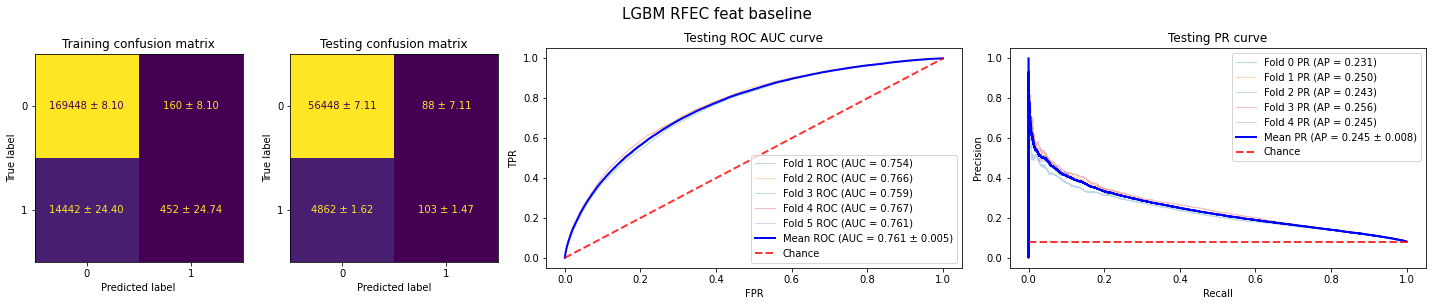

In [ ]:
plot_baseline_metrics(lgbm_baseline, title="LGBM RFEC feat baseline")

Feature selection based on shap values increases the performance of the model without any hyperparameter tuning.

## Hyperparameter tuning

In [ ]:
from sklearn.metrics import average_precision_score


def lgbm_objective(trial, X, y):
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 16, 64),
        "max_depth": trial.suggest_int("max_depth", 4, 16),
        "min_child_samples": trial.suggest_int("min_child_samples", 16, 512),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 3, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 3, log=True),
        "subsample": trial.suggest_float("subsample", 0.7, 1),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 100),
        "min_child_weight": trial.suggest_float("min_child_weight", 10, 40),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.01, 0.1),
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = np.empty(3)
    for idx, (train_idx, eval_idx) in enumerate(cv.split(X, y)):
        X_train, X_eval = X.iloc[train_idx], X.iloc[eval_idx]
        y_train, y_eval = y.iloc[train_idx], y.iloc[eval_idx]
        model = LGBMClassifier(
            n_estimators=10000, device="gpu", verbosity=-1, **param_grid
        )
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_eval, y_eval)],
            eval_metric="auc",
            callbacks=[
                early_stopping(50, verbose=False),
            ],
        )
        preds = model.predict_proba(X_eval)
        cv_scores[idx] = roc_auc_score(y_eval, preds[:, 1])

    return cv_scores.mean()

In [ ]:
lgbm_study = optuna.create_study(
    direction="maximize",
    study_name="lgbm_rfec_auc",
    storage="sqlite:////content/drive/MyDrive/lgbm_tune_rfec.db",
    load_if_exists=True,
)
func = lambda trial: lgbm_objective(trial, X_train[rfec_col], y_train)

[I 2022-06-13 15:12:26,808] A new study created in RDB with name: lgbm_rfec_auc


In [ ]:
# lgbm_study.optimize(func, n_trials=100)

In [ ]:
%%capture
lgbm_rfec = LGBMClassifier(device="gpu", n_estimators=10000, **lgbm_study.best_params)
lgbm_rfec.fit(
    X_train[rfec_col],
    y_train,
    eval_set=[(X_eval[rfec_col], y_eval)],
    eval_metric="auc",
    callbacks=[early_stopping(50, verbose=False)],
)

In [ ]:
def xgb_objective(trial, X, y):
    param_grid = {
        "n_estimators": 10000,
        "learning_rate": trial.suggest_float("learning_rate", 0.003, 1),
        "num_leaves": trial.suggest_int("num_leaves", 16, 64),
        "max_depth": trial.suggest_int("max_depth", 4, 16),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 1),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 1),
        "gama": trial.suggest_float("gama", 0, 16),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.7, 1),
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = np.empty(3)

    for idx, (train_idx, eval_idx) in enumerate(cv.split(X, y)):
        X_train, X_eval = X.iloc[train_idx], X.iloc[eval_idx]
        y_train, y_eval = y.iloc[train_idx], y.iloc[eval_idx]

        model = XGBClassifier(tree_method="gpu_hist", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_eval, y_eval)],
            eval_metric="auc",
            early_stopping_rounds=50,
            verbose=False,
        )
        preds = model.predict_proba(X_eval)
        cv_scores[idx] = average_precision_score(y_eval, preds[:, 1])

    return np.mean(cv_scores)

In [ ]:
xgb_study = optuna.create_study(
    direction="maximize",
    study_name="XGB_tune2",
    storage="sqlite:////content/drive/MyDrive/XGB_tune.db",
    load_if_exists=True,
)
func = lambda trial: xgb_objective(trial, X_train[col_xgb], y_train)

[I 2022-06-13 09:00:53,119] Using an existing study with name 'XGB_tune2' instead of creating a new one.


In [ ]:
# xgb_study.optimize(func, n_trials=100)

In [ ]:
xgb = XGBClassifier(tree_method="gpu_hist", **xgb_study.best_params)
xgb.fit(
    X_train[col_xgb],
    y_train,
    eval_set=[(X_eval[col_xgb], y_eval)],
    eval_metric="auc",
    early_stopping_rounds=50,
    verbose=False,
)

XGBClassifier(gama=1.3025194482669789, learning_rate=0.03990725796411809,
              max_depth=4, min_child_weight=2, num_leaves=27,
              reg_alpha=7.169883586731477, reg_lambda=0.001523814492673584,
              subsample=0.7791330001743124, tree_method='gpu_hist')

In [ ]:
from catboost import CatBoostClassifier, Pool
import optuna


def cat_objective(trial, X, y):
    param_grid = {
        "iterations": 10000,
        "eval_metric": "AUC",
        "depth": trial.suggest_int("depth", 2, 16),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 0, 90, step=3),
        "bagging_temperature": trial.suggest_int("bagging_temperature", 0, 50),
        "random_strength": trial.suggest_int("random_strength", 0, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 4, 512),
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = np.empty(3)

    for idx, (train_idx, eval_idx) in enumerate(cv.split(X, y)):
        X_train, X_eval = X.iloc[train_idx], X.iloc[eval_idx]
        y_train, y_eval = y.iloc[train_idx], y.iloc[eval_idx]

        train_data = Pool(
            data=X_train,
            label=y_train,
        )
        eval_data = Pool(
            data=X_eval,
            label=y_eval,
        )

        model = CatBoostClassifier(task_type="GPU", **param_grid)
        model.fit(train_data, eval_set=[eval_data], early_stopping_rounds=50, verbose=0)
        preds = model.predict_proba(X_eval)
        cv_scores[idx] = roc_auc_score(y_eval, preds[:, 1])

    return np.mean(cv_scores)

In [ ]:
cat_study = optuna.create_study(
    direction="maximize",
    study_name="ctb_auc",
    storage="sqlite:////content/drive/MyDrive/cat_tune.db",
    load_if_exists=True,
)
func = lambda trial: cat_objective(trial, X_train[col_ctb], y_train)

[I 2022-06-13 09:00:55,347] Using an existing study with name 'ctb_auc' instead of creating a new one.


In [ ]:
# cat_study.optimize(func, n_trials=100)

In [ ]:
train_data = Pool(
    data=X_train[col_ctb],
    label=y_train,
)
eval_data = Pool(
    data=X_eval[col_ctb],
    label=y_eval,
)

catb = CatBoostClassifier(task_type="GPU", **cat_study.best_params)
catb.fit(train_data, eval_set=[eval_data], early_stopping_rounds=50, verbose=0)

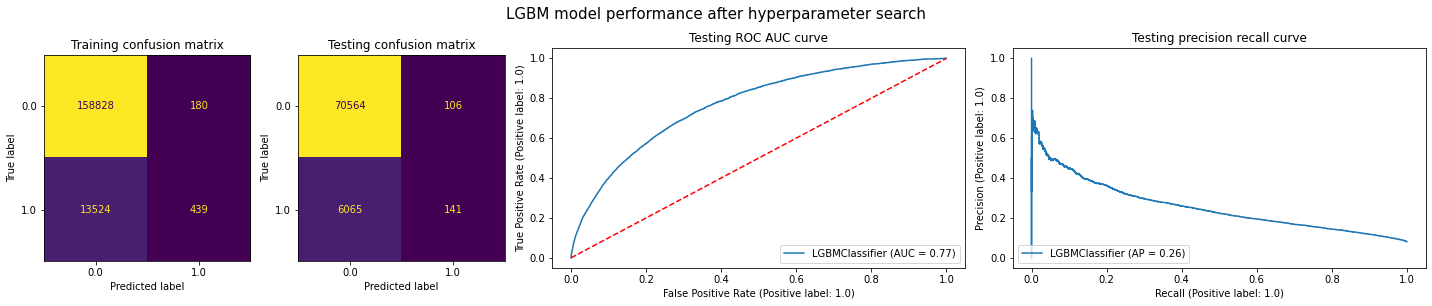

In [ ]:
plot_model_metrics(
    lgbm_rfec,
    X_train[rfec_col],
    X_test[rfec_col],
    y_train,
    y_test,
    size=(20, 4),
    normalize=None,
    title="LGBM RFEC model performance after hyperparameter search",
)

In [ ]:
print(classification_report(y_test, lgbm_rfec.predict(X_test[rfec_col])))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     70670
         1.0       0.57      0.02      0.04      6206

    accuracy                           0.92     76876
   macro avg       0.75      0.51      0.50     76876
weighted avg       0.89      0.92      0.88     76876



Lgbm model with shap selected features got a nice boost form hyperparameter search.

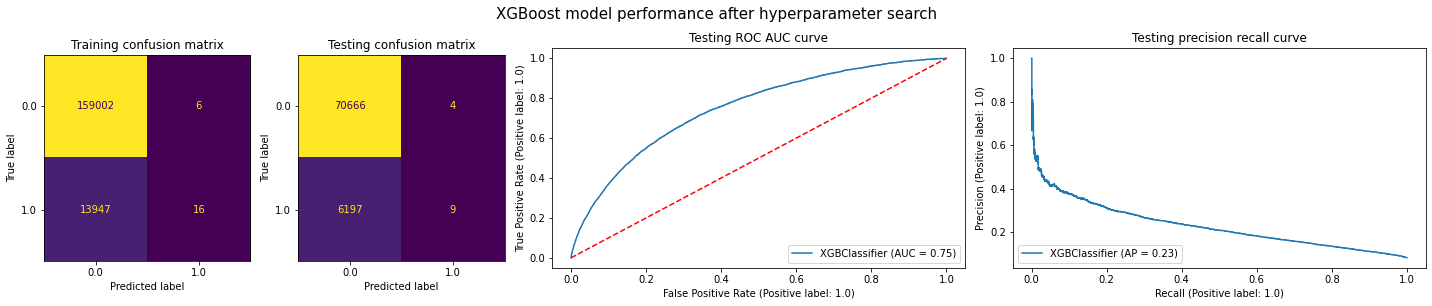

In [ ]:
plot_model_metrics(
    xgb,
    X_train[col_xgb],
    X_test[col_xgb],
    y_train,
    y_test,
    size=(20, 4),
    normalize=None,
    title="XGBoost model performance after hyperparameter search",
)

In [ ]:
print(classification_report(y_test, xgb.predict(X_test[col_xgb])))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     70670
         1.0       0.69      0.00      0.00      6206

    accuracy                           0.92     76876
   macro avg       0.81      0.50      0.48     76876
weighted avg       0.90      0.92      0.88     76876



XGBoost performance became even worse, probably got stuck with not optimal parameters and more trials are needed or the search space was badly defined.

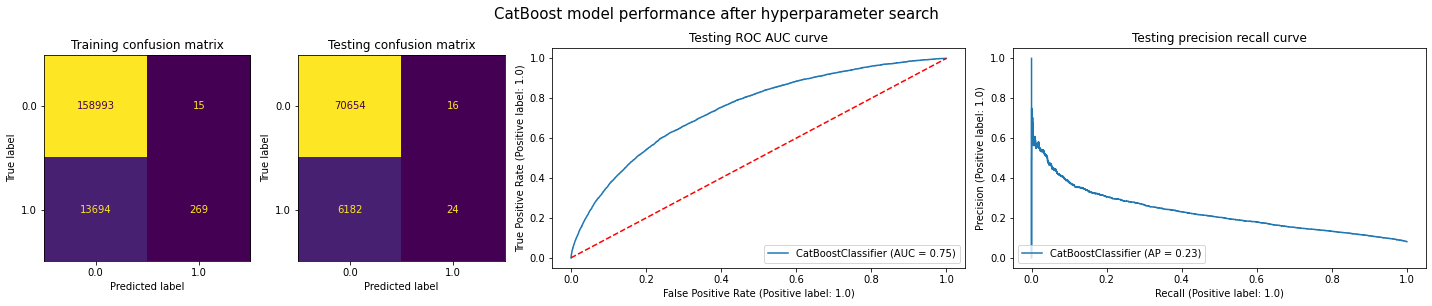

In [ ]:
plot_model_metrics(
    catb,
    X_train[col_ctb],
    X_test[col_ctb],
    y_train,
    y_test,
    size=(20, 4),
    normalize=None,
    title="CatBoost model performance after hyperparameter search",
)

In [ ]:
print(classification_report(y_test, catb.predict(X_test[col_ctb])))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     70670
         1.0       0.60      0.00      0.01      6206

    accuracy                           0.92     76876
   macro avg       0.76      0.50      0.48     76876
weighted avg       0.89      0.92      0.88     76876



Catboost parameter also did not improve but this is because it kept crashing for some reason on GPU and training on cpu takes too long so I gave with only a few trials.

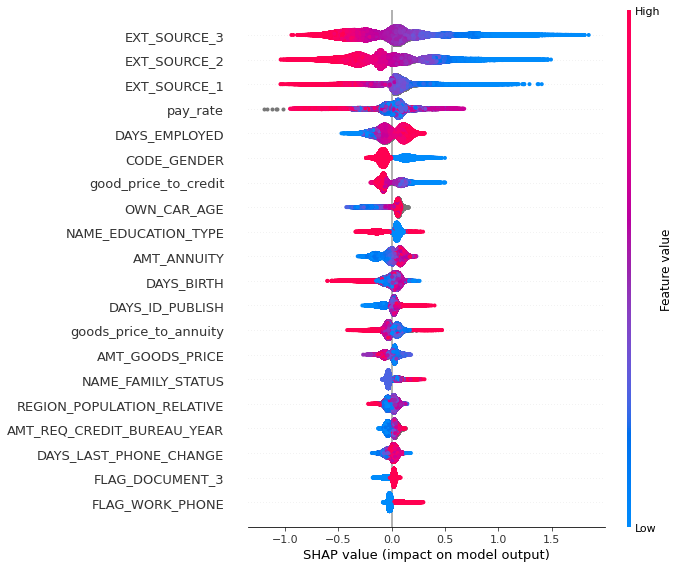

In [92]:
lgbm_feat = pd.DataFrame(
    data=lgbm_rfec.feature_importances_,
    index=X_train[rfec_col].columns,
    columns=["imp"],
).sort_values("imp", ascending=False)

lgbm_explainer = shap.TreeExplainer(lgbm_rfec)
lgbm_shap_values = lgbm_explainer(X_train[rfec_col].values)
shap.summary_plot(lgbm_shap_values[:, :, 1], feature_names=X_train[rfec_col].columns)

Same features remained important for the tuned lgbm model.

In [20]:
# joblib.dump(lgbm_rfec, '/content/drive/MyDrive/lgbm_rfec_model.dump')
lgbm_rfec = joblib.load("/content/drive/MyDrive/lgbm_rfec_model.dump")

## Playing arround with the decision boundry

Lest find a cutoff point that would maximize the f1-score

In [27]:
X_test = X_test[rfec_col]
X_train = X_train[rfec_col]

In [28]:
proba = lgbm_rfec.predict_proba(X_train)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, proba)
fscore = np.nan_to_num((2 * precision * recall) / (precision + recall))
fix = np.argmax(fscore)
print(
    f"Decision threshold of {thresholds[fix]:.3f} had the highest f1-score of {fscore[fix]:.2f}"
)

Decision threshold of 0.166 had the highest f1-score of 0.36


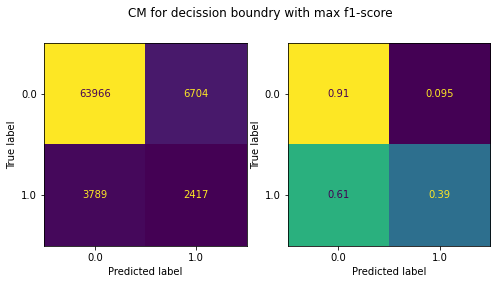

In [29]:
def custom_threshold(model, X, thresh):
    proba = model.predict_proba(X)[:, 1]
    return np.where(proba >= thresh, 1, 0)


preds_f1 = custom_threshold(lgbm_rfec, X_test, thresholds[fix])

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ConfusionMatrixDisplay.from_predictions(y_test, preds_f1, colorbar=False, ax=ax[0])
ConfusionMatrixDisplay.from_predictions(
    y_test, preds_f1, normalize="true", colorbar=False, ax=ax[1]
)
plt.suptitle("CM for decision boundary with max f1-score")
plt.show()

In [30]:
print(classification_report(y_test, preds_f1))

              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92     70670
         1.0       0.26      0.39      0.32      6206

    accuracy                           0.86     76876
   macro avg       0.60      0.65      0.62     76876
weighted avg       0.89      0.86      0.88     76876



The decision boundary of 0.166 gives an f1-score of on the test set 0.32 for the default class. Recall improves 20 fold, but our precision suffers. Not sure if this is a good tradeoff because we get almost 4 times as many false positives as true positives.

Let's also try to create a function to judge the decision boundary based on the profit we make from giving out loans that are returned.

In [103]:
from typing import Tuple


def calc_loss_gain(credit: np.ndarray, y_proba: np.ndarray) -> Tuple[np.ndarray]:
    """
    Calculates monetary loss and gain form loan defaults
    at given decision thresholds thresholds

    Args:
      credit: array of positive credit if loan doesn't default
        and negative credit if loan defaults
      y_proba: array of decision boundary probabilities

    Returns:
      loss: monetary loss because of false positive results, can be negative if
        true positives add up to higher saving
      gain: monetary gain because of given out loan that did not default
      y_proba: decision thresholds for loss and gain values
    """

    proba_desc = np.argsort(y_proba)[::-1]
    credit = credit[proba_desc]
    y_proba = y_proba[proba_desc]

    distinct_value_indices = np.where(np.diff(y_proba))[0]
    threshold_idx = np.r_[distinct_value_indices, credit.size - 1]

    loss = np.cumsum(credit)[threshold_idx]
    gain = credit.sum() - loss

    return loss, gain, y_proba[threshold_idx]

In [104]:
def get_profits(y: np.ndarray, credit: np.ndarray) -> np.ndarray:
    """
    Makes credits of defaulted loans negative
    """

    mask = (y * -1).to_numpy()
    np.place(mask, mask == 0, [1])
    price_impacts = credit * mask

    return price_impacts


price_impacts = get_profits(y_train, X_train.AMT_CREDIT)
loss, gain, thresholds = calc_loss_gain(
    price_impacts.to_numpy(), lgbm_rfec.predict_proba(X_train)[:, 1]
)
gain_thresh = np.argmax(gain)
print(
    f"Decision threshold of {thresholds[gain_thresh]:.2f}\
 had the highest monetary gain of {gain[gain_thresh]/1e6:.0f} million"
)

Decision threshold of 0.39 had the highest monetary gain of 88132 milion


In [105]:
def get_fp(y_true, y_pred):
    fp = (y_true == 0) & (y_pred == 1)
    idx = [i for i, j in enumerate(fp) if j]
    return idx


def get_tp(y_true, y_pred):
    tp = (y_true == 1) & (y_pred == 1)
    idx = [i for i, j in enumerate(tp) if j]
    return idx


def get_fn(y_true, y_pred):
    fn = (y_true == 1) & (y_pred == 0)
    idx = [i for i, j in enumerate(fn) if j]
    return idx


def get_tn(y_true, y_pred):
    tn = (y_true == 0) & (y_pred == 0)
    idx = [i for i, j in enumerate(tn) if j]
    return idx


def calc_gain(credit: np.ndarray, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:

    tp_gain = credit[get_tp(y_true, y_pred)].sum()
    fp_loss = credit[get_fp(y_true, y_pred)].sum()
    tn_gain = credit[get_tn(y_true, y_pred)].sum()
    fn_loss = credit[get_fn(y_true, y_pred)].sum()

    return np.array([tp_gain, fp_loss, tn_gain, fn_loss])

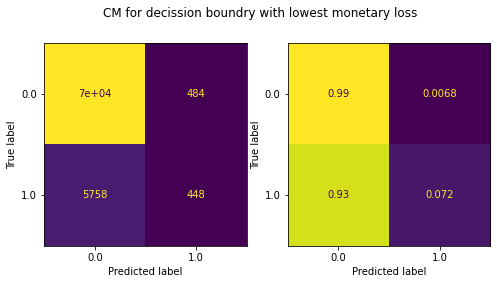

In [106]:
preds = custom_threshold(lgbm_rfec, X_test, thresholds[gain_thresh])

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ConfusionMatrixDisplay.from_predictions(y_test, preds, colorbar=False, ax=ax[0])
ConfusionMatrixDisplay.from_predictions(
    y_test, preds, normalize="true", colorbar=False, ax=ax[1]
)
plt.suptitle("CM for decision boundary with lowest monetary loss")
plt.show()

In [107]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     70670
         1.0       0.48      0.07      0.13      6206

    accuracy                           0.92     76876
   macro avg       0.70      0.53      0.54     76876
weighted avg       0.89      0.92      0.89     76876



Income maximizing model improves the model a bit but the accuracy is still basically of a dumb model.

In [108]:
test_price_impacts = get_profits(y_test, X_test.AMT_CREDIT)
baseline = test_price_impacts.sum()
perfect_baseline = np.sum(test_price_impacts.to_numpy(), where=(test_price_impacts > 0))
base_gains = calc_gain(X_test.AMT_CREDIT.to_numpy(), y_test, lgbm_rfec.predict(X_test))
f1_gains = calc_gain(X_test.AMT_CREDIT.to_numpy(), y_test, preds_f1)
thresh_gains = calc_gain(X_test.AMT_CREDIT.to_numpy(), y_test, preds)

In [109]:
print(f"Baseline profit in millions if we accept all loans: {baseline/1e6:.0f}")
print(
    f"Baseline profit in millions if we have a perfect model: {perfect_baseline/1e6:.0f}"
)
print(
    f"Profit in millions with regular lgbm model: {(base_gains[2] - base_gains[3])/1e6:.0f}"
)
print(f"Profit in millions with max f1-score: {(f1_gains[2] - f1_gains[3])/1e6:.0f}")
print(
    f"Profit in millions with highest gain models: {(thresh_gains[2] - thresh_gains[3])/1e6:.0f}"
)

Baseline profit in milions if we accept all loans: 39156
Baseline profit in milions if we have a perfect model: 42616
Profit in milions with regular lgbm model: 39167
Profit in milions with max f1-score: 36951
Profit in milions with highest gain models: 39133


On the test set the base lgbm model without threshold tuning still performs the best, beating the max profit threshold on the test dataset, and it also outperforms the baseline of just accepting all loans.

In [110]:
loss, gain, thresholds = calc_loss_gain(
    test_price_impacts.to_numpy(), lgbm_rfec.predict_proba(X_test)[:, 1]
)
gain_thresh = np.argmax(gain)
preds = custom_threshold(lgbm_rfec, X_test, thresholds[gain_thresh])
thresh_gains = calc_gain(X_test.AMT_CREDIT.to_numpy(), y_test, preds)
print(
    f"Profit in millions with highest gain models: {(thresh_gains[2] - thresh_gains[3])/1e6:.0f}"
)

Profit in milions with highest gain models: 39174


If we tune the threshold on the test set we do get the most profit then.

# Conclusions

* External sources, age, occupation, gender are best predictors of ability to repay loans. (Gender might discriminate?) 
* Data from previous loans is less important than current loan details.  
* Males seem more likely to fail payment.
* Base lgbm model performs better than model which had its decision thresholds tunned.

Improvements:
* Try some feature selection/engineering improvements, maybe generating various almost random features and seeing if it improves performance for a simple model, if it does keep it.
* More hyperparameter tuning with xgboost and catboost.


